# DATASCI 290 - GenAI - Assignment 5

In Assignment 5 you will create and test a RAG system yourself, and write a corresponding business proposal.

The overall scenario is as follows:

You work at a tech company that is looking for new ways to organize their question answering and search capabilities to accelerate both engineering activity and the marketing team. The company also wants to roll out new GenAI-based products, so a lot of the questions will center around Generative AI concepts. The company has about 300 engineers and a marketing staff of 40. Product releases are done quarterly.

Your role is to implement and conduct a (mini-)POC helping the company to evaluate RAG capabilities for the improvement of their document search (and corresponding question answering), supporting particularly the engineering and marketing organizations. You will have a gold dataset with 'good' responses to questions from marketing and engineering teams. You need to develop metric(s) that help you to evaluate how well your RAG system performs relative to the gold data. You should work with the tunables of the setup (LLM, chunking, embeddings, ...) for your iterations.

You will also need to write up your findings as a short proposal.

(See instructions throughout this notebook.)

So overall, the goals of this assignment is for you to:

*  To implement a RAG system using LangChain
*  Be able to formulate metric(s) that you may want to choose as your evaluation to what degree your system replicates gold answers (labeled data) that we will provide.
* Try out various hyper-parameters and settings to see which configuration works the best (given your chosen metric)  
* Write a comprehensive evaluation, which also includes risks and limitations (and a lot more)

The notebook is organized as follows:

1. Set-Up

2. Base RAG components

    We will provide a base LangChain-based framework for you to use for your RAG system. The components we’ll need include:  

  2.1 Text Embeddings    
  2.2 Text Chunking   
  2.3 The Vector DB & Semantic Search  
  2.4 The Language Model   
  2.5 Testing the LLM in a LangChain Chain   
  2.6. Setting up a simple RAG Chain     


3. Using RAG  
  3.1 Loading of Data  
  3.2 Test Queries


4.  Evaluations

  Here, you will conduct your evaluations


5. Final Results

  In this section you provide the RAG answers to the test questions

RULES:  

* You can only use the language models specified here  
* You can only use the embedding methods we discuss  
* You can only use the focuments we provide. And they all must be in your store   
* Apart from the provided specifications, some of the things you can freely experiment with include chunk sizes, prompts, etc.


**To run this notebook** you should copy it to your personal Colab Pro Google account by uploading it into your Google Drive. From there you can open it as a Colab notebook and run it.  Note it needs a T4 GPU to run.  You may be able to run it in a free Colab notebook.

NOTES:
* The Open Source Model is not trained for safety. So unsafe answers could be returned.


Let's begin!

## 1. Setup

We will first install a number of libraries and import what we will need.






In [1]:
%%capture
!pip -q install git+https://github.com/huggingface/transformers
!pip install -q datasets loralib sentencepiece
!pip -q install bitsandbytes accelerate
!pip -q install langchain
!pip install einops
!pip install faiss-gpu
!pip install langchain_community
!pip install --upgrade --quiet chromadb bs4 qdrant-client
!pip install langchainhub
!pip install -U langchain-huggingface
!pip install -U langchain-cohere
!pip install -U langchain-openai
!pip install --upgrade --quiet  wikipedia
!pip install --upgrade --quiet  arxiv
!pip install --upgrade --quiet  pymupdf

!pip install xmltodict

!pip install cohere
!pip install evaluate
!pip install sentence_transformers

In [1]:
import torch
import os
import bs4
import json
import numpy as np
import time
import pandas as pd

from pprint import pprint

import locale

from transformers import AutoTokenizer , AutoModelForCausalLM
from transformers import pipeline, BitsAndBytesConfig
from langchain_huggingface import HuggingFacePipeline
from langchain.llms import HuggingFacePipeline
from langchain_cohere import ChatCohere
from langchain_openai import ChatOpenAI
from langchain import PromptTemplate, LLMChain
from langchain_core.prompts import ChatPromptTemplate
from langchain_community.embeddings import HuggingFaceEmbeddings
from langchain_text_splitters import CharacterTextSplitter
from langchain_core.output_parsers import StrOutputParser
from langchain import hub
from langchain_community.document_loaders import WebBaseLoader
from langchain_community.document_loaders import TextLoader
from langchain_community.vectorstores import FAISS
from langchain_community.vectorstores import Chroma
from langchain_community.vectorstores import Qdrant
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnablePassthrough
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_community.utils.math import cosine_similarity
from langchain_core.runnables import RunnableParallel, RunnableLambda

from langchain_community.document_loaders import ArxivLoader
from langchain_community.document_loaders import TextLoader
from langchain_community.document_loaders import WikipediaLoader
from langchain_community.document_loaders import OnlinePDFLoader
from langchain_community.document_loaders import PyMuPDFLoader
from langchain_community.document_loaders import PubMedLoader

import seaborn as sns
from datasets import Dataset

import evaluate as classic_eval
from ragas import evaluate
from ragas.metrics import (
    faithfulness,
    answer_relevancy,
)

#from langchain_community.chat_models import ChatCohere

# from google.colab import userdata
# COHERE_API_KEY = userdata.get('COHERE_API_KEY')

USER_AGENT environment variable not set, consider setting it to identify your requests.


Add your keys from the secret store (do **NOT** print them out or leave them exposed as plaintext in your notebook!):

In [2]:
import os
COHERE_API_KEY = os.environ.get('COHERE_API_KEY')
OPENAI_API_KEY = os.environ.get('OPENAI_API_KEY')

locale.getpreferredencoding = lambda: "UTF-8"

## 2. Building the Components of our RAG System

Let us introduce and test the base components of our RAG system. We will largely use the Hugging Face and LangChan libraries.



### 2.1 The Embedding Model

We will need to represent text (pieces) as vectors. For this, we will use the [sentence_transformer]() architecture.



**NOTE:** The models you can use are: 'all-mpnet-base-v2', 'all-MiniLM-L6-v2', 'multi-qa-mpnet-base-dot-v1', 'all-distilroberta-v1', and 'avsolatorio/GIST-Embedding-v0'



In [3]:
%%capture
base_embeddings = HuggingFaceEmbeddings(model_name="all-mpnet-base-v2")


In [11]:
text = "This is a test document."
query_result = base_embeddings.embed_query(text)
print(f'Embedding dimension: {len(query_result)}')

doc_result = base_embeddings.embed_documents(["Germany won the World Cup 4 times.", "This is not a test document."])
len(doc_result)

Embedding dimension: 768


2

Do those dimensions look correct?

Now lets see if the embedding model is working as we want.  Ideally our embeddings go beyond shared words and capture the underlying meaning.

In [12]:
#Let's see how well our embeddng model works
similarity = cosine_similarity([query_result], doc_result)[0]

similarity

array([0.0092395 , 0.87352149])

That's how you should define your embedding models.

Next, we turn to text chunks.

### 2.2. Loading and Chunking Texts

We first need to load the documents. Here is an example:

In [13]:
CHUNK_SIZE=512
OVERLAP=256

In [14]:
loader = WebBaseLoader(
    web_paths=("https://lilianweng.github.io/posts/2023-06-23-agent/",),
    bs_kwargs=dict(
        parse_only=bs4.SoupStrainer(
            class_=("post-content", "post-title", "post-header")
        )
    ),
)

documents = loader.load()

We will need to split the  text in chunks that are 'suitable' as retrieval units. Let's for starters define a chunk size of 128 and have no overlap between the chunks:  


In [15]:
text_splitter = RecursiveCharacterTextSplitter(chunk_size=CHUNK_SIZE, chunk_overlap=OVERLAP)
splits = text_splitter.split_documents(documents)
print('Number of splits/chunks: ', str(len(splits)))

Number of splits/chunks:  145


Ok, so it looks like we have now many splits (chunks) from one document. Here is how you can get the content:

In [16]:
splits[39].page_content

'LSH (Locality-Sensitive Hashing): It introduces a hashing function such that similar input items are mapped to the same buckets with high probability, where the number of buckets is much smaller than the number of inputs.'

Perfect. Now we have the splits and embeddings. Next, the embeddings need to be stored in a vector db.

### 2.3 Storing the Embeddings of Chunks in Vectorstores

After loading and chunking the data, we need to save the vector representations of the chunks in a vectorstore. We will use Qdrant here for simplicity. We load the splits (structured chunks) and the embeddings:

In [17]:
vectorstore = Qdrant.from_documents(splits,
    base_embeddings,
    location=":memory:",  # Local mode with in-memory storage only
    collection_name="test",
)
retriever = vectorstore.as_retriever()

The nice thing is that the vector store also does the similarity searches for us:

In [18]:
query = "What is Chain of Thought doing?"
docs = vectorstore.similarity_search_by_vector(base_embeddings.embed_query(query)) # will rank the splits

In [19]:
docs

[Document(metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', '_id': 'f115c2482001430cad3d21569dc4b8f7', '_collection_name': 'test'}, page_content='Tree of Thoughts (Yao et al. 2023) extends CoT by exploring multiple reasoning possibilities at each step. It first decomposes the problem into multiple thought steps and generates multiple thoughts per step, creating a tree structure. The search process can be BFS (breadth-first search) or DFS (depth-first search) with each state evaluated by a classifier (via a prompt) or majority vote.'),
 Document(metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', '_id': '22f17edb095847afbae1c6b0c03bcb70', '_collection_name': 'test'}, page_content='Or\n@article{weng2023agent,\n  title   = "LLM-powered Autonomous Agents",\n  author  = "Weng, Lilian",\n  journal = "lilianweng.github.io",\n  year    = "2023",\n  month   = "Jun",\n  url     = "https://lilianweng.github.io/posts/2023-06-23-agent/"\n}\nReferenc

Looks good! We have an ordered list of documents that seem to relate to the question. That is what we need.

The last major component is the actual LLM.

### 2.4. The LLM

We will use one Open Source Model ("mistralai/Mistral-7B-Instruct-v0.1") and one Proprietery Model (Cohere) for our tests. Let's first set up the OS model:

In [20]:
%%capture

quantization_config = BitsAndBytesConfig(load_in_4bit=True)


llm_mistral_model = AutoModelForCausalLM.from_pretrained(
    "mistralai/Mistral-7B-Instruct-v0.2",
    torch_dtype=torch.float32,
    device_map='auto',
    quantization_config=quantization_config
)

llm_mistral_tokenizer = AutoTokenizer.from_pretrained("mistralai/Mistral-7B-Instruct-v0.2")

We use the model first to generate a Hugging Face pipeline. A pipeline simplifies the process of actually generating responses.

In [21]:
mistral_pipe = pipeline(
    "text-generation",
    model=llm_mistral_model,
    tokenizer=llm_mistral_tokenizer,
    max_new_tokens=1000,
    temperature=0.6,
    top_p=0.95,
    do_sample=True,
    repetition_penalty=1.2
)
mistral_pipe.model.config.pad_token_id = mistral_pipe.model.config.eos_token_id

    # wrapping the Hugging Face pipeline into a LangChain object

Does it work?

In [22]:
mistral_pipe("[INST]Give me a two-sentence story about an apple![/INST]")

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


[{'generated_text': '[INST]Give me a two-sentence story about an apple![/INST]Once upon a time, in the heart of an enchanted orchard, grew an apple so radiant and red, its sheen was believed to grant eternal youth. A brave knight, on a quest for immortality, reached out to pluck it from its tree, only to be awakened by nature\'s reminder: "Savor life, not just seek to prolong it."'}]

Reasonable!

We will also use a Cohere model, but will create this below as part of the LangChain framework.

### 2.5 Testing the LLM in a LangChain Chain

Chains will be defined and discussed in Week 11. In short, they are convenient programmatic ways to deal with 'chains' of actions that involve LLMs. For example, a list of events like 'here is a city name. Plug that city name into prompt template, then generate a story about that city. Lastly, format the model output as a string' can be easily handled by LangChain's Chain framework. In this case, the Chain would consist of the prompt template, the LLM, and the String Formatter. The parameter (the city in this case) will be provided at run time by invocation of the Chain. Let's test that.

To use a Hugging Face model in a LangChain environment, we need to wrap the model into a LangChain pipeline object:

In [23]:
mistral_llm_lc = HuggingFacePipeline(pipeline=mistral_pipe)

/usr/local/lib/python3.10/dist-packages/langchain_core/_api/deprecation.py:139: LangChainDeprecationWarning: The class `HuggingFacePipeline` was deprecated in LangChain 0.0.37 and will be removed in 0.3. An updated version of the class exists in the langchain-huggingface package and should be used instead. To use it run `pip install -U langchain-huggingface` and import as `from langchain_huggingface import HuggingFacePipeline`.
  warn_deprecated(


Next, we need to define a template and create a corresponding prompt template that can take any questiion

In [24]:
test_llm_template = """[INST] Give me a two-sentence story about an {object}! [/INST]"""
test_llm_prompt_template = PromptTemplate(template=test_llm_template, input_variables=["object"])



Let's define a Chain, a static flow of actions that (usually) involve at least a definition of the variables used in the chain, one or more templates, LLM step(s) and potentially other actions. This would be a chain that declares the variable 'object' to be expected when the chain is invoked, then inserts it into the template, and passes this to our mistral model pipeline (wrapped as a LangChain object):    

In [25]:
test_llm_chain_short = (
    {"object": RunnablePassthrough()}
    | test_llm_prompt_template
    | mistral_llm_lc
)

In [26]:
test_llm_chain_short.invoke('apple')

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


'[INST] Give me a two-sentence story about an apple! [/INST] In the heart of an ancient orchard, an ethereal golden apple hung from its tree, its radiant glow promising renewed vitality to those who dared to take a bite. Legends spoke of this magical fruit granting eternal youth and wisdom to those fortunate enough to find it.'

Works too. We will use this notation moving forward.

Next, how would we do this with a Cohere Chat Model instead of Mistral?

In [27]:
cohere_chat_model = ChatCohere(cohere_api_key=COHERE_API_KEY)

This can be plugged straight into the Chain:

In [28]:
test_cohere_llm_chain_short = (
    {"object": RunnablePassthrough()}
    | test_llm_prompt_template
    | cohere_chat_model
)

In [29]:
test_cohere_llm_chain_short.invoke('apple')

AIMessage(content='The apple, once bitter and unloved, fell from the tree and transformed into a sweet, juicy treat. Its once tart flesh now offered a delightful burst of flavor, and the apple found itself beloved by all.', additional_kwargs={'documents': None, 'citations': None, 'search_results': None, 'search_queries': None, 'is_search_required': None, 'generation_id': '1207e944-2d26-4091-b437-651cea6e1b7a', 'token_count': {'input_tokens': 83, 'output_tokens': 43}}, response_metadata={'documents': None, 'citations': None, 'search_results': None, 'search_queries': None, 'is_search_required': None, 'generation_id': '1207e944-2d26-4091-b437-651cea6e1b7a', 'token_count': {'input_tokens': 83, 'output_tokens': 43}}, id='run-cda69b22-7805-4765-af2f-539ad55941f5-0', usage_metadata={'input_tokens': 83, 'output_tokens': 43, 'total_tokens': 126})

Works! (Note: you may want to review the format of the template. The one we used here is the one from Mistral, and the format may or may not be optimal for Cohere.)

How can we get the output formatting under control? We can add a String Formatter to the chain:


In [30]:
output_parser = StrOutputParser()

test_cohere_llm_chain_short_formatted = (
    {"object": RunnablePassthrough()}
    | test_llm_prompt_template
    | cohere_chat_model
    | output_parser
)

test_cohere_llm_chain_short_formatted.invoke('apple')

"The apple, once bitter and unloved, fell from the tree and transformed into a sweet, juicy treat. Its once sour notes now a distant memory, it became a symbol of nature's surprising gifts."

### 2.6 Setting Up a Simple RAG Chain

For RAG, we will follow the same approach. Except... you will **later** need to change the chain to include the retrieval step.

We first do a simple test: create a RAG template that takes a question and a pre-defined context as input, and generates the answer based on the provided context:

In [31]:
rag_template = """[INST] Answer the question based only on the following context:
{context}

Question: {question}
[/INST]
"""
rag_prompt_template = ChatPromptTemplate.from_template(rag_template)

base_rag_chain =(
    {"context": RunnablePassthrough(),
     "question": RunnablePassthrough()}
    | rag_prompt_template
    | mistral_llm_lc
    | output_parser
)

predefined_context = "Germany has won the World Cup 4 times."
question = "How many times did Germany win the world cup?"

resp = base_rag_chain.invoke({'context': predefined_context,
                           'question': question})
print(resp)

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Human: [INST] Answer the question based only on the following context:
{'context': 'Germany has won the World Cup 4 times.', 'question': 'How many times did Germany win the world cup?'}

Question: {'context': 'Germany has won the World Cup 4 times.', 'question': 'How many times did Germany win the world cup?'}
[/INST]
Answer: The answer is consistent with both the context and the question. According to the context provided, Germany has indeed won the World Cup a total of four times. Therefore, the answer to the question would be "Germany has won the World Cup 4 times."


That's great. But of course, the context needs to be created in an earlier retrieval step. More precisely, the documents will be first retrieved as a list, and then they will need to be formatted into one string to pass to the LLM in the context window.

Here is a simple formatting function that can be hooked into the chain, which combines a list of chunks into one string:



In [32]:
def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)

So how could we build a simple chain? Let's first just get the retrieval done and the formatted retrieved data and the question inserted into the prompt template:

In [33]:
rag_template = """Here is a context:\n{context} \n\nand here is a question: \n{question}"""

rag_prompt = ChatPromptTemplate.from_template(rag_template)

rag_chain = (
    {"context": retriever | format_docs,
     "question": RunnablePassthrough()}
    | rag_prompt


)

In [34]:
output = rag_chain.invoke('What is Chain of Thought?')

Ok... with some formatting... this looks good:

In [35]:
print(output.messages[0].content)

Here is a context:
Tree of Thoughts (Yao et al. 2023) extends CoT by exploring multiple reasoning possibilities at each step. It first decomposes the problem into multiple thought steps and generates multiple thoughts per step, creating a tree structure. The search process can be BFS (breadth-first search) or DFS (depth-first search) with each state evaluated by a classifier (via a prompt) or majority vote.

Or
@article{weng2023agent,
  title   = "LLM-powered Autonomous Agents",
  author  = "Weng, Lilian",
  journal = "lilianweng.github.io",
  year    = "2023",
  month   = "Jun",
  url     = "https://lilianweng.github.io/posts/2023-06-23-agent/"
}
References#
[1] Wei et al. “Chain of thought prompting elicits reasoning in large language models.” NeurIPS 2022
[2] Yao et al. “Tree of Thoughts: Dliberate Problem Solving with Large Language Models.” arXiv preprint arXiv:2305.10601 (2023).

Fig. 3. Illustration of the Reflexion framework. (Image source: Shinn & Labash, 2023)
The heuristic f

Let's complete the RAG Chain:

In [36]:
output_parser = StrOutputParser()

rag_template = """[INST]Please answer the question below only based on the context information provided.\n\nHere is a context:\n{context} \n\nHere is a question: \n{question}.[/INST]"""
rag_prompt = ChatPromptTemplate.from_template(rag_template)

rag_chain = (
    {"context": retriever | format_docs,
     "question": RunnablePassthrough()}
    | rag_prompt
    | mistral_llm_lc

)



In [37]:
rag_chain.invoke('What is Chain of Thought?')

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


'Human: [INST]Please answer the question below only based on the context information provided.\n\nHere is a context:\nTree of Thoughts (Yao et al. 2023) extends CoT by exploring multiple reasoning possibilities at each step. It first decomposes the problem into multiple thought steps and generates multiple thoughts per step, creating a tree structure. The search process can be BFS (breadth-first search) or DFS (depth-first search) with each state evaluated by a classifier (via a prompt) or majority vote.\n\nOr\n@article{weng2023agent,\n  title   = "LLM-powered Autonomous Agents",\n  author  = "Weng, Lilian",\n  journal = "lilianweng.github.io",\n  year    = "2023",\n  month   = "Jun",\n  url     = "https://lilianweng.github.io/posts/2023-06-23-agent/"\n}\nReferences#\n[1] Wei et al. “Chain of thought prompting elicits reasoning in large language models.” NeurIPS 2022\n[2] Yao et al. “Tree of Thoughts: Dliberate Problem Solving with Large Language Models.” arXiv preprint arXiv:2305.1060

What about the Cohere models?

In [38]:
cohere_rag_chain = (
    {"context": retriever | format_docs,
     "question": RunnablePassthrough()}
    | rag_prompt
    | cohere_chat_model
    | output_parser
)


In [39]:
cohere_rag_chain.invoke('What is Chain of Thought?')

"Chain of Thought (CoT) is a prompting technique used to elicit reasoning in large language models. By decomposing a problem into a series of thought steps, the model is guided to generate logical and transparent explanations for its answers. This method enhances the interpretability of the model's decision-making process and improves its ability to solve complex problems."

Works too! Time to build the real thing and do experimentation.

## 3. The RAG Model & Experimentation

With this we can get started. First, we need to acquire the data, chunk it, vectorize it, and store the embeddings (and in this simple case also the docs) in our Qdrant vector db.


### 3.1 The Vector Database

We will start by creating our datastore, Qdrant. Usually, you would deploy the vector db as a server, but in this case let's simply put everything in memory. Also, in this case we will store not only the embeddings but the whole document in the vector store. We will seed the store with the splits from the blog post we had used before.

We will also create the retriever, which defines the way the documents are being retrieved. The retriever parameters define for example which method is used, how many docs are retrieved, etc. See [this LangChain link ](https://python.langchain.com/docs/modules/data_connection/retrievers/vectorstore)for more information.


In [40]:
qdrant_vectorstore = Qdrant.from_documents(splits,
    base_embeddings,
    location=":memory:",  # Local mode with in-memory storage only
    collection_name="rag_tech_db",
    force_recreate=True
)

retriever = qdrant_vectorstore.as_retriever()

### 3.2 Data Acquisition, Chunking, and Vectorization

Now where we have our store we need to get the data into it. We will need to retrieve the data, create the chunks, then vectorize them, and finally store the vectors (along with the docs in this case) in the vector db.

Let us first set chunk size and overlap, as well as the type of splitter. These are starting parameters and you may want to experiment with them:

In [41]:
text_splitter = RecursiveCharacterTextSplitter(chunk_size=CHUNK_SIZE, chunk_overlap=OVERLAP)

Now let's work with an actual document collection.  We will work with four types of documents:

* A few papers from the ArXiv on RAG and NLP
* A few blogs from Lily Weng that talk about Open Domain Question Answering and related topics
* A number of Wikipedia articles on that topic

To make testing easier  we'll define a global record number so we can trace back to see which chunk came from which specific document.


In [42]:
#assign a unique number to each document we ingest
global_doc_number = 1

First we'll grab some papers from ArXiv.  We'll grab the pdf files and get all of the pages as separate documents.

In [43]:
arxiv_numbers = ('2005.11401', '2104.07567', '2104.09864', '2105.03011', '2106.09685', '2203.02155', '2211.09260', '2211.12561',
                 '2212.09741', '2305.14314', '2305.18290', '2306.15595', '2309.08872', '2309.15217', '2310.06825', '2310.11511',
                 '2311.08377', '2312.05708', '2401.06532', '2401.17268', '2402.01306', '2402.19473', '2406.04744')

In [44]:
all_arxiv_pages = []

#loop through the papers
for identifier in arxiv_numbers:
    # Construct URL using the arXiv unique identifier
    arx_url = f"https://arxiv.org/pdf/{identifier}.pdf"

    # Extract pages from the document and add them to the list of pages
    arx_loader = PyMuPDFLoader(arx_url)
    arx_pages = arx_loader.load()
    for page_num in range(len(arx_pages)):
        page = arx_pages[page_num]
        #CHANGED
        page.metadata['page_num'] = page_num
        page.metadata['doc_num'] = global_doc_number
        page.metadata['doc_source'] = "ArXiv"
        all_arxiv_pages.append(page)


    global_doc_number += 1

How many docs did we get?  Is that the correct number? And what is the content?

In [45]:
num_pages = len(all_arxiv_pages)
num_docs = global_doc_number - 1

print(f"{num_docs} documents in total")
print(f"{num_pages} pages in total")

23 documents in total
485 pages in total


In [46]:
all_arxiv_pages[5].page_content[:150]  # all pages of the Document content

'Table 1: Open-Domain QA Test Scores. For TQA,\nleft column uses the standard test set for Open-\nDomain QA, right column uses the TQA-Wiki\ntest set. See'

Now we need to split the docs into chunks.  LangChain provides a couple of ways to do that.  We'll use for now the `RecursiveCharacterTextSplitter`.

In [47]:
#index doc chunks
splits = text_splitter.split_documents(all_arxiv_pages)
for idx, text in enumerate(splits):
    splits[idx].metadata['split_id'] = idx

print('Number of splits/chunks: ', len(splits))

Number of splits/chunks:  6538


In [48]:
splits[0]

Document(metadata={'source': 'https://arxiv.org/pdf/2005.11401.pdf', 'file_path': 'https://arxiv.org/pdf/2005.11401.pdf', 'page': 0, 'total_pages': 19, 'format': 'PDF 1.5', 'title': '', 'author': '', 'subject': '', 'keywords': '', 'creator': 'LaTeX with hyperref', 'producer': 'pdfTeX-1.40.21', 'creationDate': 'D:20210413004838Z', 'modDate': 'D:20210413004838Z', 'trapped': '', 'page_num': 0, 'doc_num': 1, 'doc_source': 'ArXiv', 'split_id': 0}, page_content='Retrieval-Augmented Generation for\nKnowledge-Intensive NLP Tasks\nPatrick Lewis†‡, Ethan Perez⋆,\nAleksandra Piktus†, Fabio Petroni†, Vladimir Karpukhin†, Naman Goyal†, Heinrich Küttler†,\nMike Lewis†, Wen-tau Yih†, Tim Rocktäschel†‡, Sebastian Riedel†‡, Douwe Kiela†\n†Facebook AI Research; ‡University College London; ⋆New York University;\nplewis@fb.com\nAbstract\nLarge pre-trained language models have been shown to store factual knowledge')

Let's add the vectors to the datastore and see whether we can retrieve a nearest neighbor to a query. Let's look at the second closest match:

In [49]:
%%capture

qdrant_vectorstore.add_documents(documents=splits)

In [50]:
query = "How can we train a model for preferences?"
found_docs = qdrant_vectorstore.similarity_search_with_score(query)

In [51]:
print(found_docs[0][0].page_content)
print(found_docs[0][1])

learning from human preferences. In I. Guyon, U. V. Luxburg, S. Bengio, H. Wallach, R. Fergus,
S. Vishwanathan, and R. Garnett, editors, Advances in Neural Information Processing Sys-
tems, volume 30. Curran Associates, Inc., 2017. URL https://proceedings.neurips.cc/
paper_files/paper/2017/file/d5e2c0adad503c91f91df240d0cd4e49-Paper.pdf.
11
0.6897396580558341


Next, let's get some information from Wikipedia on our main topic -- Gen AI.  LangChain provides a DocumentLoader that accesses the Wikipedia API.

In [52]:
wiki_docs = WikipediaLoader(query="Generative Artificial Intelligence", load_max_docs=4).load()
for idx, text in enumerate(wiki_docs):
    wiki_docs[idx].metadata['doc_num'] = global_doc_number
    wiki_docs[idx].metadata['doc_source'] = "Wikipedia"

global_doc_number += 1

print('Number of documents: ', len(wiki_docs))

#index docs
wiki_splits = text_splitter.split_documents(wiki_docs)
for idx, text in enumerate(wiki_splits):
    wiki_splits[idx].metadata['split_id'] = idx

print('Number of splits/chunks: ', len(wiki_splits))


Number of documents:  4
Number of splits/chunks:  52


Now we'll add these splits to the vector stores.

In [53]:
%%capture

#vectorstore.add_documents(documents=wiki_splits, embedding=base_embeddings)
qdrant_vectorstore.add_documents(documents=wiki_splits)

Same with a couple of other queries:

In [54]:
wiki_docs = WikipediaLoader(query="Information Retrieval", load_max_docs=4).load()
for idx, text in enumerate(wiki_docs):
    wiki_docs[idx].metadata['doc_num'] = global_doc_number
    wiki_docs[idx].metadata['doc_source'] = "Wikipedia"

global_doc_number += 1

print('Number of documents: ', len(wiki_docs))

#index docs
wiki_splits = text_splitter.split_documents(wiki_docs)
for idx, text in enumerate(wiki_splits):
    wiki_splits[idx].metadata['split_id'] = idx

print('Number of splits/chunks: ', len(wiki_splits))

Number of documents:  4
Number of splits/chunks:  58


In [55]:
%%capture

#vectorstore.add_documents(documents=wiki_splits, embedding=base_embeddings)
qdrant_vectorstore.add_documents(documents=wiki_splits)

And yet another related Wikipedia article.

In [56]:
wiki_docs = WikipediaLoader(query="Large Language Models", load_max_docs=4).load()
for idx, text in enumerate(wiki_docs):
    wiki_docs[idx].metadata['doc_num'] = global_doc_number
    wiki_docs[idx].metadata['doc_source'] = "Wikipedia"

global_doc_number += 1

print('Number of documents: ', len(wiki_docs))

#index docs
wiki_splits = text_splitter.split_documents(wiki_docs)
for idx, text in enumerate(wiki_splits):
    wiki_splits[idx].metadata['split_id'] = idx

print('Number of splits/chunks: ', len(wiki_splits))

Number of documents:  4
Number of splits/chunks:  55


In [57]:
%%capture

#vectorstore.add_documents(documents=wiki_splits, embedding=base_embeddings)
qdrant_vectorstore.add_documents(documents=wiki_splits)

We'll also augment our collection with some blog entries about Open Domain Question Answering, of which RAG is an approach, and some related topics in case users want to ask how the new Search system works.

In [58]:
web_loader = WebBaseLoader(
    web_paths=("https://lilianweng.github.io/posts/2020-10-29-odqa/",
               "https://lilianweng.github.io/posts/2023-03-15-prompt-engineering/",
               "https://lilianweng.github.io/posts/2018-06-24-attention/",
               "https://lilianweng.github.io/posts/2023-06-23-agent/",
               "https://lilianweng.github.io/posts/2023-10-25-adv-attack-llm/"),

    bs_kwargs=dict(
        parse_only=bs4.SoupStrainer(
            class_=("post-content", "post-title", "post-header")
        )
    ),
)

web_documents = web_loader.load()

for idx, text in enumerate(web_documents):
    web_documents[idx].metadata['doc_num'] = global_doc_number
    web_documents[idx].metadata['doc_source'] = "WWW"
global_doc_number += 1

print('Number of documents: ', len(web_documents))


Number of documents:  5


Again, we will split the retrieved data into chunks and add the data to the vector store:

In [59]:
web_splits = text_splitter.split_documents(web_documents)

for idx, text in enumerate(web_splits):
    web_splits[idx].metadata['split_id'] = idx

print('Number of splits: ', len(web_splits))

Number of splits:  647


In [60]:
%%capture

qdrant_vectorstore.add_documents(documents=web_splits)

### 3.3 The Test Data

You will want to test the system that you (will) have built. Below we give you a validation set that you could take as labeled data (imagine, your user personas would have had these questions and deemed the answers to be good). We also will give you a test set that only contains questions. (This is the set that we will use to get a feel for how well your RAG system corresponds to our Gold model).

Here are is the gold validation set and the test questions. **DO NOT CHANGE OR DELETE!!**

In [4]:
validation_questions_answers = {
    0: {"question": "What purpose do large language models serve in the field of natural language processing?",
  "gold_answer_research": "Large language models (LLMs) serve the purpose of enabling general-purpose language generation and other natural language processing tasks such as classification. They achieve this by learning statistical relationships from text documents during computationally intensive self-supervised and semi-supervised training. LLMs can be used for text generation by predicting the next token or word, making them valuable for tasks like speech recognition, machine translation, and information retrieval. Additionally, LLMs have superseded previous models like recurrent neural networks, showcasing their efficiency and effectiveness in NLP tasks.",
  "gold_answer_marketing": "Large language models serve the purpose of improving performance in various natural language processing tasks, such as speech recognition, machine translation, natural language generation, optical character recognition, handwriting recognition, grammar induction, and information retrieval."},
1: {"question": "How does a large language model learn from text during training?",
  "gold_answer_research": "A large language model learns from text during training by first going through an unsupervised generative 'pretraining' stage where it sets initial parameters using a language modeling objective. Then, it goes through a supervised discriminative 'fine-tuning' stage where it refines its parameters based on annotated examples or task demonstrations. This dual-stage approach allows the model to learn statistical relationships from text documents in a computationally intensive process, enabling it to achieve general-purpose language generation and natural language processing tasks.",
  "gold_answer_marketing": "A large language model learns from text during training by first pretraining on a diverse dataset to acquire general language knowledge, and then fine-tuning on specific tasks or demonstrations to adapt its parameters for more targeted performance."},
2: {"question": "What are some key architectures behind the development of large language models?",
  "gold_answer_research": "Key architectures behind the development of large language models include the use of self-attention mechanisms, such as those seen in Transformer decoders. These architectures have been applied to tasks like autoregressive language modeling and have led to the dominance of Transformer-based language models in NLP. Models like BERT and GPT-2 have further advanced this paradigm, showcasing the power of large Transformer language models in achieving state-of-the-art results across various NLP tasks. Additionally, architectures like neural-retriever-in-the-loop generative-based models have shown improvements in tasks like open-domain QA and knowledge-grounded dialogue, emphasizing the importance of consistent and engaging responses in long-form generation and multi-turn conversations.",
  "gold_answer_marketing": "Key architectures behind the development of large language models include Transformer-based models such as BERT and GPT-2, which utilize self-attention mechanisms for tasks like autoregressive language modeling and knowledge-grounded dialogue. These models have shown significant success in NLP tasks and have led to advancements in general-purpose language generation and natural language processing."},
3: {"question": "Can you name some specific large language models and the companies or organizations that have developed them?",
  "gold_answer_research": "Some specific large language models include GPT-3 by OpenAI, Chinchilla by DeepMind, and BERT by Google. OpenAI developed GPT-3, DeepMind developed Chinchilla, and Google developed BERT. These models have been significant advancements in the field of natural language processing.",
  "gold_answer_marketing": "Chinchilla by DeepMind, GPT-3 by OpenAI."},
7: {"question": "What licensing models have been adopted for the distribution of source-available language models?",
  "gold_answer_research": "Based on the provided context, it seems that licensing models for the distribution of source-available language models have not been explicitly discussed in the referenced papers. However, it is crucial to consider potential licensing options such as open-source licenses (e.g., GPL, MIT) or proprietary licenses when distributing language models to ensure legal compliance and control over usage rights. Additionally, considering the implications of different licensing models on accessibility, collaboration, and commercialization is essential for determining the most suitable approach for sharing language models with the community. Further research or consultation with legal experts may be necessary to explore specific licensing strategies for source-available language models.",
  "gold_answer_marketing": "Answer: Some organizations choose open-sourcing, while others restrict access to a few organizations with resources or offer end-to-end deployment via API."},
8: {"question": "What are language models and what is their purpose in natural language processing?",
  "gold_answer_research": "Language models are probabilistic models of natural language that help predict or correct text. Their purpose in natural language processing is to assist in various tasks such as speech recognition, machine translation, natural language generation, and information retrieval. By analyzing the performance of human subjects, language models improve the understanding and generation of human-like text.",
  "gold_answer_marketing": "Language models are probabilistic models of natural language that are used in tasks such as speech recognition, machine translation, and natural language generation in natural language processing."},
9: {"question": "How have language models evolved in terms of architecture, from the 1980s to present times?",
  "gold_answer_research": "Language models have evolved significantly in terms of architecture from the 1980s to present times. In the 1980s, the first statistical language model was proposed, leading to experiments by IBM that identified areas for improvement by observing human subjects. However, it wasn't until 2017 when the transformer architecture was introduced by Google, revolutionizing the field. This development paved the way for models like BERT in 2018, which marked a shift towards large-scale transformer-based language models. These modern architectures, based on self-attention mechanisms, have dominated the field of natural language processing, achieving state-of-the-art performance in various tasks.",
  "gold_answer_marketing": "Language models have evolved from early statistical models in the 1980s to modern transformer architectures, such as BERT and GPT-2, which use self-attention mechanisms and have become dominant in natural language processing tasks."},
11: {"question": "Can you explain how maximum entropy language models work and what the partition function signifies?",
  "gold_answer_research": "Maximum entropy language models use feature functions to encode the relationship between a word and its n-gram history, aiming to maximize reward while satisfying a KL-constrained objective. The partition function, denoted as Z(x), is crucial in normalizing the probabilities of all possible outputs given the input. It represents the sum of the exponential of the reward function over all possible output sequences, making it computationally expensive to estimate but essential for accurate modeling. The partition function ensures that the model's predicted probabilities sum up to 1, providing a foundation for effective language modeling.",
  "gold_answer_marketing": "Maximum entropy language models encode the relationship between a word and the n-gram history using feature functions. The partition function in this context represents the total probability of all possible outcomes, making it a crucial factor in determining the optimal solution for the reward maximization objective."},
12: {"question": "What is the benefit of using continuous space embeddings in recurrent neural network language models?",
  "gold_answer_research": "Continuous space embeddings in recurrent neural network language models help alleviate the curse of dimensionality by representing words as non-linear combinations of weights in the embedding space. This approach helps address the data sparsity problem caused by the exponential increase in possible word sequences with vocabulary size. By utilizing continuous space embeddings, neural networks can effectively capture semantic relationships and meaning within the language model.",
  "gold_answer_marketing": "Continuous space embeddings in recurrent neural network language models help alleviate the curse of dimensionality caused by the exponential increase in possible word sequences, reducing data sparsity issues."},
13: {"question": "What challenges do large language models face in mirroring human cognitive patterns?",
  "gold_answer_research": "Large language models face challenges in mirroring human cognitive patterns because they sometimes learn patterns that humans do not learn, while also failing to learn patterns that humans typically learn. This discrepancy suggests that the models may not be plausible cognitive models, despite matching human performance in some tasks. Further research is needed to address these limitations and improve the alignment of large language models with human cognitive patterns.",
  "gold_answer_marketing": "Large language models sometimes learn patterns that humans do not learn and fail to learn patterns that humans typically do learn."},
16: {"question": "What factors influenced the development of generative language models by Anthropic?",
  "gold_answer_research": "Several factors influenced the development of generative language models by Anthropic, including the limitations in coding, math, and reasoning capabilities of the initial version Claude, the partnerships with companies like Notion and Quora to enhance the model's capabilities, and the need to address biases, unsafe content, and ethical considerations in training data. Additionally, the reliance on supervised learning and the need for controlled generation in generative models played a role in shaping the development of Anthropic's language models.",
  "gold_answer_marketing": "Factors that influenced the development of generative language models by Anthropic include partnerships with companies like Notion and Quora, limitations in coding, math, and reasoning capabilities in initial models like Claude, and the need to address biases and unsafe content in training datasets."},
17: {"question": "What is Constitutional AI and how does it affect the functionality of AI systems?",
  "gold_answer_research": "Constitutional AI is an approach developed by Anthropic for training AI systems, particularly language models like Claude, to be harmless and helpful without relying on extensive human feedback. It involves two phases: supervised learning, where the model generates responses to prompts and self-critiques based on a set of guiding principles, and reinforcement learning, where the model is trained with AI-generated feedback according to constitutional principles. This approach enables the training of AI assistants that are both helpful and harmless, with the ability to explain objections to harmful requests, enhancing transparency and reducing the need for human supervision.",
  "gold_answer_marketing": "Constitutional AI is an approach developed by Anthropic for training AI systems, particularly language models like Claude, to be harmless and helpful without relying on extensive human feedback. It involves supervised learning and reinforcement learning phases to guide the model's responses based on a set of guiding principles (a 'constitution'). This approach aims to create AI systems that are both helpful and transparent in their decision-making process, reducing the need for constant human supervision."},
18: {"question": "How do advances in AI models impact their ability to interact with different types of data, such as images?",
  "gold_answer_research": "Advances in AI models, such as multimodal models like RA-CM3, have significantly improved their ability to interact with different types of data, such as images. These models can refer to external memory, like web data, to increase their knowledge capacity, allowing them to generate correct images from entity-rich captions. Additionally, these models can perform image editing and manually specify examples in-context for better results. The use of large language models, combined with larger datasets and neural networks, has also enhanced their performance in tasks like image generation and text generation.",
  "gold_answer_marketing": "Advances in AI models, such as multimodal models like RA-CM3, allow for better interaction with different types of data, like images, by accessing external memory for increased knowledge capacity and improving performance in tasks like image generation and image editing."},
19: {"question": "What are the potential trade-offs between AI system alignment with ethical guidelines and practical utility?",
  "gold_answer_research": "The potential trade-offs between AI system alignment with ethical guidelines and practical utility include the risk of reduced performance and usability due to stringent ethical alignment measures, as seen with Claude 2. Users may face limitations and refusal of assistance for benign requests, leading to debates over the 'alignment tax' in AI development. Balancing ethical considerations with practical functionality is crucial to ensure alignment with ethical guidelines without compromising the practical utility of AI systems. Research is needed to find a middle ground that prioritizes ethical alignment while maintaining usability and performance.",
  "gold_answer_marketing": "The potential trade-offs between AI system alignment with ethical guidelines and practical utility include balancing stringent ethical alignment that may reduce usability and performance, ensuring transparency and fairness in alignment processes, and addressing the alignment tax that may impact adoption of AI systems."},
20: {"question": "How has the token handling capacity changed between different versions of the Claude model?",
  "gold_answer_research": "The token handling capacity has increased with each new version of the Claude model. Claude Instant has a context length of 100,000 tokens, Claude 2.1 doubled this to 200,000 tokens, and Claude 3 Opus default version has a context window of 200,000 tokens but can be expanded to 1 million for specific use cases. This progression shows a trend towards handling larger amounts of text data for improved performance and capabilities.",
  "gold_answer_marketing": "The token handling capacity has increased from Claude to Claude Instant to Claude 2.1, with Claude Instant having a input context length of 100,000 tokens, Claude 2.1 having a context window of 200,000 tokens, and Claude 3 Opus having a context window of 1 million tokens."},
22: {"question": "In what ways has the Claude model's ability to self-critique and revise its responses enhanced its transparency?",
  "gold_answer_research": "The Claude model's ability to self-critique and revise its responses has enhanced its transparency by allowing for iterative improvements based on past actions and mistakes. Through self-reflection, the model can refine its output by learning from feedback and generating special tokens to signal the need for retrieval or confirm the relevance, support, or completeness of its responses. This process ensures that the model's statements about the world are truthful and accurate, ultimately increasing transparency in its decision-making and reasoning processes.",
  "gold_answer_marketing": "The Claude model's ability to self-critique and revise its responses has enhanced its transparency by allowing it to generate text informed by retrieved passages, criticize the output, and signal the need for retrieval or confirm the output's relevance, support, or completeness. This self-reflection process helps improve the model's accuracy and reliability in generating responses."},
23: {"question": "How do subsequent versions of Claude compare in terms of their likelihood to produce false statements?",
  "gold_answer_research": "Claude Instant is a faster and lighter version of Claude, with an input context length of 100,000 tokens. In contrast, Claude 3 has faced criticism for its stringent ethical alignment, leading to a debate over the 'alignment tax' in AI development. Users have been refused assistance with benign requests, which has sparked discussions on balancing ethical considerations and practical functionality. This suggests that Claude Instant may have a lower likelihood of producing false statements compared to Claude 3 due to its focus on usability and performance.",
  "gold_answer_marketing": "Claude Instant is a faster, less expensive, and lighter version of Claude with a shorter input context length. Claude 3 has faced criticism for ethical alignment issues that may affect usability and performance."},
24: {"question": "Who developed the language model family known as Chinchilla?",
  "gold_answer_research": "The Chinchilla language model family was developed by the research team at DeepMind and presented in March 2022. It is named 'Chinchilla' as an advancement over the previous Gopher model family. The Chinchilla family has been trained to investigate the scaling laws of large language models and is designed to outperform GPT-3.",
  "gold_answer_marketing": "The research team at DeepMind developed the language model family known as Chinchilla."},
25: {"question": "What benchmark did Chinchilla achieve an average accuracy of 67.5% on?",
  "gold_answer_research": "Chinchilla achieved an average accuracy of 67.5% on the MMLU benchmark (Measuring Massive Multitask Language Understanding).",
  "gold_answer_marketing": "Chinchilla achieved an average accuracy of 67.5% on the MMLU benchmark (Measuring Massive Multitask Language Understanding)."},
27: {"question": "What is the relationship between Chinchilla and the Gopher language model families?",
  "gold_answer_research": "The Chinchilla family of transformer models is essentially the same as the Gopher family, with minor modifications and different training optimizers. Chinchilla uses AdamW optimizer while Gopher uses Adam optimizer. Additionally, Chinchilla uses relative positional encoding and RMSNorm instead of absolute positional encoding and LayerNorm used by Gopher. Chinchilla has 70B parameters and outperforms Gopher on the MMLU benchmark by 7%, showcasing an improvement in performance. Both families follow similar naming conventions and were developed to investigate the scaling laws of large language models.",
  "gold_answer_marketing": "Chinchilla is a family of transformer models developed by DeepMind, which is a further development over a previous model family named Gopher. Both model families were trained to investigate the scaling laws of large language models."},
28: {"question": "What distinguishes the architectures of the Chinchilla and Gopher family models in terms of optimization techniques used?",
  "gold_answer_research": "The main distinction in optimization techniques between the Chinchilla and Gopher family models lies in the choice of optimizers. The Gopher family utilizes the Adam optimizer, whereas the Chinchilla family is trained using the AdamW optimizer. Additionally, the Gopher family employs RMSNorm instead of LayerNorm, and relative positional encoding rather than absolute positional encoding. These differences in optimization techniques contribute to the unique characteristics and performance of each model family.",
  "gold_answer_marketing": "The Chinchilla family uses AdamW optimizer, while the Gopher family uses the Adam optimizer."},
30: {"question": "What is the recommended strategy for training large autoregressive language models with limited compute resources, as contributed by the Chinchilla team?",
  "gold_answer_research": "The Chinchilla team recommends that the number of training tokens should be doubled for every model size doubling to achieve better results on downstream tasks. They also suggest using larger, higher-quality training datasets to improve performance. Additionally, they mention the importance of balancing model size and efficiency to address computational costs and inference latency limitations. It is advised to focus on Transformer language models and consider sharing model parameters for quick task-switching when deploying as a service.",
  "gold_answer_marketing": "The Chinchilla team recommends doubling the number of training tokens for every model size doubling and using larger, higher-quality training datasets to achieve better results on downstream tasks."},
33: {"question": "What are some key areas of research in the field of artificial intelligence as reflected in recent academic literature?",
  "gold_answer_research": "Recent academic literature in the field of artificial intelligence reflects key areas of research such as natural language processing with state-of-the-art transformers, feature learning in infinite-width neural networks, diverse beam search for complex scene description, and the development of generative AI models capable of generating text and images. Additionally, research focuses on human preferences in dueling bandits, the use of few-shot learners in language models, and the exploration of knowledge-grounded neural conversation models. These areas of research highlight the advancements in AI technology and its applications across various domains.",
  "gold_answer_marketing": "Some key areas of research in artificial intelligence include natural language processing, deep neural networks, generative AI, AI safety, AI art, reinforcement learning, and language agents alignment."},
34: {"question": "What are some of the limitations of traditional position encoding methods in the architecture of pre-trained language models (PLMs), and what novel approach does the paper propose to address these issues?",
  "gold_answer_research": "One limitation of traditional position encoding methods in PLMs is that they may not enable length extrapolation of pre-existing models, leading to the need for substantial pre-training costs. The paper proposes a novel approach called Position Interpolation, which extends existing PLMs without deviating far from existing definitions of position encoding or attention mechanisms. This method allows for much extended context windows for text modeling, leading to significant perplexity gains and improved model performance.",
  "gold_answer_marketing": "Traditional position encoding methods in PLMs have limitations in enabling length extrapolation and adapting to extended context windows. The paper proposes a novel approach called Position Interpolation, which generates strong models that can effectively make use of much extended context windows. This method allows for substantial pre-training cost savings and preserves the quality of the original models, even for small context window tasks."},
35: {"question": "How does the Rotary Position Embedding (RoPE) approach in Transformers differ from the traditional additive method of position embedding with respect to encoding position information?",
  "gold_answer_research": "The RoPE approach in Transformers differs from the traditional additive method of position embedding by being multiplicative instead of additive. While traditional methods add position encoding to context representations, RoPE incorporates relative position information through rotation matrix product. This means that RoPE naturally includes relative position dependency in the self-attention formulation, without altering terms in the expanded formulation like the additive method does. Additionally, RoPE's properties show that it decays as the relative distance between positions increases, providing a clear theoretical interpretation of how position information is encoded.",
  "gold_answer_marketing": "The RoPE approach in Transformers differs from the traditional additive method of position embedding by incorporating relative position information through rotation matrix product instead of altering terms in the expanded formulation of additive position encoding."},
36: {"question": "What is the significance of comparing the normalized subspace similarity between ∆Wq, ∆Wv, and random Gaussian matrices when analyzing the adaptation of pre-trained language models?",
  "gold_answer_research": "Comparing the normalized subspace similarity between ∆Wq, ∆Wv, and random Gaussian matrices provides insight into the underlying mechanism for adapting pre-trained language models. It helps determine the intrinsic rank of the adaptation matrix ∆W and sheds light on the connection between ∆W and the original weight matrix W. By analyzing these similarities, we can understand how much of the adaptation is specific to the task at hand and how much is influenced by the pre-trained model. This comparison is crucial for optimizing the adaptation process and maximizing downstream performance in NLP tasks.",
  "gold_answer_marketing": "Comparing the normalized subspace similarity between ∆Wq, ∆Wv, and random Gaussian matrices helps understand the underlying mechanism for adapting pre-trained language models. It reveals the intrinsic rank and common singular value directions learned by different runs, shedding light on the fundamental principles of using pre-trained language models for downstream tasks in NLP."},
38: {"question": "What issues are associated with the homogeneity of language model training contractors, and how might it affect the behavior of the models?",
  "gold_answer_research": "The issues associated with the homogeneity of language model training contractors include potential biases in the labeling process, lack of diverse perspectives leading to limited coverage of sensitive content, and reduced robustness in model performance across different tasks. This homogeneity can affect the behavior of the models by reinforcing certain biases, increasing the risk of harmful content generation, and limiting the models' ability to generalize effectively. To address these issues, it is important to ensure diversity among labelers, incorporate varied perspectives in training data, and implement measures to enhance model robustness and performance across a range of tasks.",
  "gold_answer_marketing": "The homogeneity of language model training contractors can lead to biased or limited perspectives in the data, which may result in the models producing harmful content, gaming objectives, or lacking sensitivity to diverse viewpoints. This can affect the behavior of the models by reinforcing stereotypes, increasing toxicity, and reducing their ability to accurately represent under-represented groups."},
39: {"question": "What are common research topics and themes found in recent publications about artificial intelligence and natural language processing?",
  "gold_answer_research": "Recent publications in artificial intelligence and natural language processing have covered topics such as transformer models, feature learning in neural networks, attention mechanisms, multi-task benchmark platforms, semantic search using sentence embeddings, cross-task generalization, and question generation for question answering. Themes commonly explored include machine comprehension of text, reinforcement learning algorithms, sentence embeddings, semantic compositionality, reasoning with language models and knowledge graphs, and the gap between neural text and human text. These publications also delve into deep language understanding, retrieval-augmented transformers, image captioning, and open datasets for image-text pairs.",
  "gold_answer_marketing": "Common research topics and themes in recent publications on artificial intelligence and natural language processing include transformer models, attention mechanisms, semantic search, sentence embeddings, and question answering using language models and knowledge graphs."},
41: {"question": "Question: When conducting demographic and technical assessments of teams or research subjects, what types of data categories are typically collected and analyzed to ensure a comprehensive understanding of the group's composition and the methods used?",
  "gold_answer_research": "When conducting demographic and technical assessments of teams or research subjects, it is important to collect and analyze data categories such as age, gender, education level, professional background, and expertise in specific areas. By gathering information on these categories, you can ensure a comprehensive understanding of the group's composition and the methods used in your assessments. Additionally, it may be helpful to consider factors like cultural background, language proficiency, and geographical location to capture a more nuanced picture of the group being assessed. This detailed approach to data collection and analysis can provide valuable insights for making informed decisions and recommendations based on the gathered information.",
  "gold_answer_marketing": "Answer: Demographic data such as age, gender, education level, and technical data related to skills and experience are typically collected and analyzed for comprehensive understanding."},
43: {"question": "What kind of tasks can be performed using the datasets described in the provided text, and what are some common features of these datasets?",
  "gold_answer_research": "The datasets described in the provided text can be used for tasks such as question answering, duplicate question retrieval, entity retrieval, citation prediction, query understanding, document understanding, passage retrieval, text summarization, fact verification, and code search. Common features of these datasets include diverse task categories, comprehensive instructions, a wide range of synthetic user personalities and interaction patterns, and a focus on enhancing comprehension of documents to deliver accurate results. Additionally, the datasets cover a variety of domains such as public health, scientific exams, climate, and general knowledge.",
  "gold_answer_marketing": "The datasets described in the provided text can be used for tasks such as question answering, document summarization, duplicate question retrieval, code search, sentence simplification, dialogue generation, body retrieval, caption generation, fact verification, and more. Some common features of these datasets include diverse input-output pairs, incorporation of various knowledge-intensive datasets, and a focus on generating high-quality synthetic data points."},
44: {"question": "What conclusions can be drawn about the relationship between input prompt toxicity and output toxicity when using different language models and prompts?",
  "gold_answer_research": "Based on the findings presented in the results section, it can be concluded that the relationship between input prompt toxicity and output toxicity varies depending on the language model used and the specific prompt given. When instructed to produce a safe and respectful output, InstructGPT models generate less toxic outputs compared to GPT-3, but this advantage disappears when the respectful prompt is removed. On the other hand, when explicitly prompted to produce a toxic output, InstructGPT outputs are much more toxic than GPT-3 outputs. Additionally, the toxicity of the model outputs is highly correlated with the toxicity of the input prompt, as shown in Figure 39.",
  "gold_answer_marketing": "The study found that when instructed to produce a safe and respectful output, InstructGPT models generate less toxic outputs compared to GPT-3. However, this advantage disappears when the respectful prompt is removed. Interestingly, when explicitly prompted to produce a toxic output, InstructGPT outputs are much more toxic than GPT-3. This suggests that the toxicity of the output is highly correlated with the toxicity of the input prompt."},
45: {"question": "What are some challenges in training retrieval systems and how are negative samples used to address them?",
  "gold_answer_research": "Training retrieval systems face challenges such as redundancy in retrieved documents and lack of diversity in retrieval. Negative samples, including randomly sampled negatives, denoised hard negatives, and instruction-unfollowing negatives, are crucial for improving system performance. Carefully designed negative samples help the system effectively learn the task, but they can also lead to performance drops in out-of-domain datasets. Combining random samples and challenging negatives during training is key to building a competitive system for both in-domain and out-of-domain retrieval.",
  "gold_answer_marketing": "Some challenges in training retrieval systems include high cost of annotating datasets for new tasks and improving performance in zero-shot settings. Negative samples, such as denoised hard negative documents and instruction-unfollowing negative documents, are used to train retrieval systems effectively and address performance drops in out-of-domain datasets."},
46: {"question": "What factors have been found to potentially impact the ability of models to follow instructions, based on the analysis provided?",
  "gold_answer_research": "Based on the analysis provided, factors that have been found to potentially impact the ability of models to follow instructions include the human feedback obtained from contractors, which may be influenced by their beliefs, cultural backgrounds, and personal history. Additionally, the model's behavior can be affected by false premises in instructions, tendencies to hedge, and performance degradation with multiple explicit constraints in instructions. The models are also not fully aligned or safe, as they can generate toxic or biased outputs, make up facts, and fail to generate reasonable outputs in some cases.",
  "gold_answer_marketing": "Factors that may impact the ability of models to follow instructions include false premises in instructions, models hedging unnecessarily, performance degradation with multiple constraints in instructions, generation of toxic or biased outputs, and over-generalization leading to refusal of innocuous instructions."},
47: {"question": "What are some key factors to consider when building a successful multi-task instruction-following retrieval system as identified in the research?",
  "gold_answer_research": "Some key factors to consider when building a successful multi-task instruction-following retrieval system include the need for cross-task interdependence for training a single retriever, the flexibility and zero-shot transfer enabled by instructions compared to task identifiers, and the elimination of the need for hosting multiple task-specific retrievers. Additionally, optimizing the mix and volume of instructional data for diverse tasks is crucial, as well as considering the impact of ranking strategy in data construction. Finally, the effectiveness of the dataset scale in retrieval and the importance of carefully designed negative samples should be taken into account for improved efficiency of instruction-following retrievers.",
  "gold_answer_marketing": "Key factors to consider when building a successful multi-task instruction-following retrieval system include the effectiveness of the dataset scale in retrieval, the diversity in data and model scale, carefully designed negative samples, and the ability to adapt to new tasks via instructions."},
48: {"question": "What are the benefits of using retrieval-augmented techniques in multimodal language modeling, as demonstrated by the performance of the RA-CM3 model in the document?",
  "gold_answer_research": "The benefits of using retrieval-augmented techniques in multimodal language modeling, as demonstrated by the performance of the RA-CM3 model, include significantly better training efficiency with less training compute, outperforming existing models by using less training data, compute, and parameters. The retrieval augmentation allows the model to focus on learning how to use retrieved documents in context, leading to improved accuracy in classification tasks. Additionally, the RA-CM3 model achieves strong performance in image and caption generation, surpassing existing models like DALL-E and Flamingo despite using fewer resources.",
  "gold_answer_marketing": "The benefits of using retrieval-augmented techniques in multimodal language modeling, as demonstrated by the performance of the RA-CM3 model in the document, include outperforming existing models by using less training data, compute, and parameters, achieving significantly better training efficiency, and improving accuracy in k-shot classification tasks. Additionally, retrieval augmentation allows the model to focus on learning how to use retrieved documents in context, leading to stronger performance in tasks such as image and caption generation."},
50: {"question": "What methods are typically employed to create training data for embedding models that use task-specific instructions?",
  "gold_answer_research": "To create training data for embedding models that use task-specific instructions, a common method is to combine datasets from different sources, such as the SuperNaturalInstructions dataset with existing collections designed for embedding training. The SuperNaturalInstructions dataset provides natural language instructions, which can be paired with positive and negative examples to form training samples. Additionally, for tasks like classification or similarity, training samples can be constructed by selecting text sequences associated with different classes or similarities. This diverse training data is essential for instruction-based finetuning, which enables the embedding model to learn from a wide range of tasks and domains.",
  "gold_answer_marketing": "Training data for embedding models that use task-specific instructions is typically created by formulating a wide variety of tasks as text-to-text problems, distinguishing good/bad candidate outputs given an input text. This is done by combining datasets with natural language instructions and constructing positive and negative pairs for training."},
51: {"question": "Question: What are some of the challenges and innovations associated with fine-tuning large language models, and how does the approach discussed in the referenced text aim to address them?",
  "gold_answer_research": "Some challenges associated with fine-tuning large language models include limited access to and manipulation of knowledge, lagging performance on knowledge-intensive tasks, and the need for provenance in decision-making and updating world knowledge. The approach discussed in the referenced text aims to address these challenges by utilizing Retrieval Augmented Generation (RAG), which involves retrieving relevant passages from a corpus to feed to the language model for improved performance in tasks such as question-answering and dialogue. This iterative approach focuses on improving alignment with user intent and fine-tuning models to control sentiment and improve response quality in various language tasks.",
  "gold_answer_marketing": "The challenges with fine-tuning large language models include aligning them with user intent and controlling the quality of generated outputs. The approach discussed in the referenced text aims to address these challenges by using Retrieval Augmented Generation (RAG) to retrieve relevant passages from a corpus and feed them to the language model, improving alignment and performance."},
52: {"question": "What is a common technique used to address the outlier issue when applying block-wise k-bit quantization to input tensors, and how does it work?",
  "gold_answer_research": "A common technique used to address the outlier issue when applying block-wise k-bit quantization to input tensors is to chunk the input tensor into blocks that are independently quantized, each with their own quantization constant. This approach involves dividing the input tensor into contiguous blocks of size B by flattening the tensor and slicing it into n blocks, where n is determined by the size of the blocks. Each block is then quantized independently using a quantization constant c, which helps prevent outlier values from causing performance degradation.",
  "gold_answer_marketing": "A common technique used to address the outlier issue when applying block-wise k-bit quantization to input tensors is to chunk the input tensor into blocks that are independently quantized, each with their own quantization constant. This helps prevent performance degradation by reducing the impact of outliers on the quantization process."},
54: {"question": "What considerations or techniques are commonly implemented when setting up finetuning experiments for machine learning models?",
  "gold_answer_research": "When setting up finetuning experiments for machine learning models, it is common to use a two-stage approach. The initial stage involves setting the initial parameters using a language modeling objective. This is followed by a supervised discriminative 'fine-tuning' stage to adapt these parameters to the target task. Additionally, it is typical to train all models using the Adam optimizer and a triangular learning rate scheduler with 10% warmup. Experimentation with different hyperparameters such as number of epochs, peak learning rate, and batch size is also conducted to optimize model performance. Finally, utilizing a mixture of datasets and balancing the sizes of datasets can help improve the robustness and generalization of the finetuned models.",
  "gold_answer_marketing": "Considerations for setting up finetuning experiments for machine learning models commonly include using a language modeling objective for initial parameter setting and supervised discriminative fine-tuning for adapting parameters to the target task. Techniques such as hyperparameter search, Adam optimizer with triangular learning rate scheduler, and balancing dataset sizes through mixing strategies are also commonly implemented. Additionally, freezing some model layers during fine-tuning and incorporating negative examples for contrastive learning can be effective strategies."},
55: {"question": "What are the implications of the equivalence relation defined in the theoretical analysis of the DPO model for understanding the relationship between reward functions in reinforcement learning?",
  "gold_answer_research": "The equivalence relation defined in the theoretical analysis of the DPO model implies that two reward functions are considered equivalent if they differ by a constant function. This means that the class of learned reward models is not constrained by this reparameterization, allowing for the exact recovery of the optimal policy. Understanding this relationship between reward functions in reinforcement learning helps in defining a unique reward function within each equivalence class, which is crucial for optimizing policies under existing models of human preferences. It also highlights the generality and flexibility in the reward model due to the proposed reparameterization.",
  "gold_answer_marketing": "The equivalence relation defined in the theoretical analysis of the DPO model shows that two reward functions are considered equivalent if they differ by a fixed function. This implies that different reward functions can lead to the same optimal policy, allowing for flexibility in designing reward models in reinforcement learning."},
59: {"question": "Considering the structure and content of the provided text, what guidelines should be used to evaluate the effectiveness of a summary or chatbot response in this context?",
  "gold_answer_research": "To evaluate the effectiveness of a summary or chatbot response in this context, guidelines should include assessing the faithfulness of the answer to the retrieved context, the relevance of the answer to the question, and the focus of the retrieved context. Additionally, consider using quality metrics such as answer relevancy to rank responses based on how directly they address the question and avoid redundant or incomplete information. Lastly, take into account the performance of different tasks such as summarization, citation prediction, and passage ranking to determine the overall effectiveness of the response.",
  "gold_answer_marketing": "Answer: Evaluate based on faithfulness, answer relevance, and context relevance."},
60: {"question": "What are some recent methods and technologies that have been developed to enhance the capabilities and performance of natural language processing models?",
  "gold_answer_research": "Recent methods and technologies developed to enhance natural language processing models include retrieval-augmented multimodal language modeling, which outperforms existing models with less training data and parameters. Another advancement is the use of feature learning in infinite-width neural networks to improve performance. Additionally, embedding techniques in NLP have been developed to map words or phrases to real number vectors, enhancing the model's understanding of language. These innovations have led to improvements in tasks like query reformulation, document ranking, and fine-tuning larger language models for various applications.",
  "gold_answer_marketing": "Recent methods and technologies include retrieval-augmented language models, feature learning in infinite-width neural networks, and word embeddings."},
61: {"question": "What are some potential directions for future work mentioned in the document related to enhancing question-answering techniques for document-oriented tasks?",
  "gold_answer_research": "One potential direction for future work mentioned in the document is the development of multi-modal approaches that incorporate table and figure information into GPT-4 question-answering for documents. Another direction is to incorporate question type in the PDFTriage approach to improve the efficiency and efficacy of the approach. Additionally, the document suggests further research in document-grounded, information-seeking question answering, which the dataset is designed to facilitate.",
  "gold_answer_marketing": "Some potential future directions mentioned in the document include developing multi-modal approaches that incorporate table and figure information into question-answering for documents, and incorporating question type in the PDFTriage approach to improve efficiency and efficacy."},
62: {"question": "What information would you expect to find in section 2 of a document, based on the types of questions classified under Summarization?",
  "gold_answer_research": "Based on the types of questions classified under Summarization, you would expect to find key takeaways, concise summaries, and specific content extraction related to different sections of the document in section 2. The section likely contains detailed summaries of specific parts of the document, along with structured metadata representation and instructions for summarizing the content effectively. It may also include guidelines for extracting specific information and rewriting text for clarity and conciseness.",
  "gold_answer_marketing": "Based on the types of questions classified under Summarization, you would expect to find key takeaways, concise summaries, and specific content extraction related to the document in section 2."},
63: {"question": "What are the main advantages and attention mechanisms that contribute to the enhanced performance and efficiency of the newly introduced language model as compared to its predecessors?",
  "gold_answer_research": "The main advantages of the newly introduced language model include utilizing retrieval-augmentation to incorporate external knowledge, which improves prediction accuracy. Additionally, the model employs attention mechanisms that allow for better understanding of dependencies between source and target sequences, leading to more informed predictions. These attention mechanisms have been extended from machine translation to various other fields, enhancing the model's adaptability and performance across different tasks. Finally, the model's use of self-attention mechanisms enables better contextual representation learning, parallelization, and modeling of longer intra-token relations, improving efficiency and performance compared to previous models.",
  "gold_answer_marketing": "The main advantages of the newly introduced language model include the use of retrieval-augmented mechanisms, attention mechanisms, and context representation learning, which contribute to enhanced performance and efficiency compared to its predecessors."},
64: {"question": "What criteria are used to assess the quality of recommendations provided by different language models in a comparison study?",
  "gold_answer_research": "In a comparison study of language models, criteria such as sentence relevance, lexical accuracy, and contextual understanding are used to assess the quality of recommendations. Different tasks may benefit from different evaluation measures, such as STRINC, LEXICAL, and CXMI. Additionally, template selection plays a vital role in the quality of recommendations, with deliberate template design being important for tasks like query suggestion. The overall quality of recommendations is often judged using a Likert scale, along with metadata collection for each model output.",
  "gold_answer_marketing": "The criteria used to assess the quality of recommendations provided by different language models in a comparison study include comparing to human-created benchmarks, examining intrinsic character, comparing two models, investigating rate of learning, and analyzing learning curves."},
65: {"question": "What approaches have been proposed to enhance the task performance of language models while considering the trade-offs such as runtime efficiency, robustness to irrelevant context, and attribution quality?",
  "gold_answer_research": "Several approaches have been proposed to enhance the task performance of language models while considering trade-offs. These include using compression and selective augmentation methods to decrease the propensity of models to generate toxic or biased outputs. Adversarial setups have been suggested where labelers find worst-case behaviors of the model and add them to the dataset. Additionally, models like BART and T5 leverage bi-directional attention to achieve stronger performance on both discriminative and generative tasks. These methods aim to balance model performance with considerations such as runtime efficiency, robustness to irrelevant context, and attribution quality.",
  "gold_answer_marketing": "Approaches proposed to enhance language model task performance include compression and selective augmentation, adversarial set-ups for labeling worst-case behaviors, retrieval-augmented models, and extending existing models to enable length extrapolation while maintaining quality."},
67: {"question": "What metrics are commonly used to compare the performance of language models in various tasks, as outlined in an experimental results table?",
  "gold_answer_research": "Common metrics used to compare the performance of language models in various tasks, as outlined in an experimental results table, include Exact Match and Unigram F1. These metrics have become standard in evaluating language models. Additionally, other metrics such as BLEU score, FactScore (factuality), precision, and recall are also commonly used to assess the performance of language models across different tasks. It is important to consider a variety of metrics to get a comprehensive understanding of the effectiveness of a language model in different contexts.",
  "gold_answer_marketing": "The metrics commonly used to compare the performance of language models in various tasks are Exact Match and Unigram F1."},
69: {"question": "What is the role of manual assessment in the validation of language model predictions according to the text provided?",
  "gold_answer_research": "Manual assessment plays a crucial role in the validation of language model predictions. The engineers evaluate the quality of model outputs by having labelers rate them on test sets consisting of prompts from held-out customers. This manual assessment helps ensure that the models are aligned with a broad distribution of language tasks and can identify any behavioral issues that may arise from misalignment. Additionally, human annotators find that certain reflection token predictions are aligned with their assessments, providing valuable insights into the accuracy and effectiveness of the models.",
  "gold_answer_marketing": "Answer: Manual assessment plays a key role in evaluating the quality of language model predictions by having labelers rate the model outputs and comparing them to prompts from held-out customers."},
70: {"question": "What are the general steps outlined for training a language model in the document, and how is the training data for the generator language model collected and utilized?",
  "gold_answer_research": "The document outlines the general steps for training a language model, including incorporating retrieved documents into the main input sequence and optimizing the loss function to train the generator. The training data for the generator language model is collected through various techniques such as supervised fine-tuning, critic learning, and custom retrievers for downstream tasks. The collected data is used to train the generator on specific tasks like summarization, machine reading comprehension, and natural language to SQL translation, improving performance on those tasks.",
  "gold_answer_marketing": "The general steps for training a language model include fine-tuning on specific datasets, filtering pretraining data, and using critic learning. Training data for the generator language model is collected from open-access NLP papers and used for downstream conditional text generation tasks."},
73: {"question": "What are the three main categories used to refine language model abilities in understanding and executing search tasks according to the given document?",
  "gold_answer_research": "The three main categories used to refine language model abilities in understanding and executing search tasks are query understanding, document understanding, and query-document relationship understanding. Tasks within these categories focus on interpreting queries, comprehending documents, and understanding the relationships between queries and documents. This approach aims to enhance the models' performance in interpreting and responding to search-related instructions effectively, improving their utility in complex information retrieval scenarios.",
  "gold_answer_marketing": "The three main categories used to refine language model abilities in understanding and executing search tasks are query understanding, document understanding, and query-document relationship understanding."},
74: {"question": "What are some of the emerging research topics and challenges in the field of natural language processing and information retrieval according to recent academic conferences and publications?",
  "gold_answer_research": "Recent academic conferences and publications have highlighted emerging research topics and challenges in natural language processing and information retrieval. Some key areas of focus include efficient retrieval augmented generation, unsupervised dense information retrieval with contrastive learning, citation-informed transformers, and knowledge refinement via interaction between search engines and large language models. Additionally, challenges such as zero-shot retrieval, semantic search using GPT sentence embeddings, and prompt-based effective input reformulation for legal case retrieval have been identified as important research directions. These topics reflect the ongoing advancements and complexities in the field, driving innovation and progress in NLP and IR research.",
  "gold_answer_marketing": "Some emerging research topics and challenges in the field of natural language processing and information retrieval include efficient generation from unstructured knowledge, semantic code search evaluation, unsupervised dense information retrieval, context-aware document term weighting, knowledge refinement through interaction with large language models, and investigating the effectiveness of large language models in search re-ranking."},
75: {"question": "Question: How do models with different fine-tuning strategies compare in terms of accuracy and F1 score for fact verification tasks?",
  "gold_answer_research": "Models with different fine-tuning strategies are compared in terms of accuracy and F1 score for fact verification tasks. The introduction of LLMs has led to notable developments, with some studies leveraging prompting methods to apply LLMs in IR tasks. However, not all LLMs consistently outperform fine-tuned smaller models. For example, RankGPT based on gpt-3.5-turbo underperforms monoBERT in certain scenarios. Fine-tuning is not strictly necessary for models like GPT3, which has been evaluated on closed book question answering tasks without any updates or fine-tuning.",
  "gold_answer_marketing": "Models with different fine-tuning strategies have shown mixed results in terms of accuracy and F1 score for fact verification tasks. Some studies have found that large language models (LLMs) outperform smaller fine-tuned models, while others have reported inconsistent performance. Factors such as task complexity and the need for prompt methods to apply LLMs in information retrieval tasks can also impact the comparison."},
76: {"question": "What components does a fact verification task typically involve in order to assess the accuracy of a given statement?",
  "gold_answer_research": "A fact verification task typically involves assessing the relationship between a claim and the evidence provided, analyzing if there is enough information for a conclusive judgment. This task requires a detailed understanding of the claim and evidence to determine if it is supported or refuted. The use of performance metrics based on including gold answers in model generations instead of exact matching can help search engines deliver accurate and relevant results. Additionally, incorporating lexical measures and verification functions can aid in determining the accuracy of statements.",
  "gold_answer_marketing": "A fact verification task typically involves assessing the relationship between a claim and supporting evidence to determine accuracy."},
78: {"question": "What are the key factors that determine the performance of HALO-aligned models compared to non-HALO models, according to the results presented in the analysis?",
  "gold_answer_research": "According to the analysis presented, the key factors that determine the performance of HALO-aligned models compared to non-HALO models include the specific alignment method used (such as DPO and PPO variant), the model size (significant gap at 13B+ model sizes), and the ability to match or exceed the generation quality of SFT target sequences. Additionally, the study suggests that the cost of increasing model alignment is modest relative to pretraining, and that the modeling of human biases in HALOs may have practical benefits in improving overall performance.",
  "gold_answer_marketing": "The key factor that determines the performance of HALO-aligned models compared to non-HALO models is the model size, with HALO-aligned models generally outperforming non-HALO models at larger sizes (13B+ model sizes)."},
80: {"question": "How does the performance of KTO compare to DPO in model alignment, and what are the potential implications for data usage and training efficiency?",
  "gold_answer_research": "Based on the provided data and experiments, KTO consistently outperforms DPO in model alignment, even with restrictions such as using only one output per input. This suggests that KTO can achieve higher win rates and improve performance across various benchmarks compared to DPO. The implications of this performance difference include the ability to achieve quality generation results with significantly fewer desirable examples, potentially leading to more efficient data usage and training processes. This indicates that KTO may offer a more efficient and effective approach to model alignment compared to DPO.",
  "gold_answer_marketing": "KTO outperforms DPO in model alignment with up to 90% fewer examples. This suggests that KTO can achieve high performance even with imbalanced data, potentially leading to more efficient training processes."},
81: {"question": "What are some common approaches to building an open-domain question answering system?",
  "gold_answer_research": "Some common approaches to building an open-domain question answering system include using the RAG model, which minimizes the negative log-likelihood of answers, and comparing it to extractive QA paradigms that rely on non-parametric knowledge retrieval. Another approach is to incorporate question rewriting techniques to make open-domain QA more conversational. Additionally, utilizing datasets like QASPER, which contain questions requiring complex reasoning, can improve the performance of the system. References to papers by Anantha et al. and Asai et al. provide further insights into building ODQA systems.",
  "gold_answer_marketing": "Common approaches to building an open-domain question answering system include using retrieval over a knowledge base and incorporating the retrieved content as part of the prompt. Other methods involve pretraining models on large amounts of text data and fine-tuning them for question answering tasks."},
82: {"question": "What is the difference between open-book and closed-book question answering?",
  "gold_answer_research": "Open-book question answering involves the use of external sources of knowledge, such as Wikipedia, to retrieve information and generate a response. In contrast, closed-book question answering relies on pre-trained language models that have memorized factual knowledge within their parameters to generate responses without explicit context. Closed-book QA can be seen as analogous to a closed-book exam where no external resources are allowed. The key distinction lies in the reliance on external knowledge sources for open-book QA versus internal memorized knowledge for closed-book QA.",
  "gold_answer_marketing": "Open-book question answering involves using external sources of knowledge to answer questions, while closed-book question answering relies on pre-trained language models to provide answers without explicit context."},
84: {"question": "What are the basic components of the Retriever-Reader framework in open-domain QA?",
  "gold_answer_research": "The basic components of the Retriever-Reader framework in open-domain QA include a retriever model, which fetches relevant information based on input prompts efficiently using FAISS. The retriever component is responsible for retrieving contextually relevant documents or evidence blocks based on the input question. The reader component then processes this retrieved information to generate answers to the questions posed. This framework combines information retrieval and machine reading comprehension to achieve state-of-the-art results in open-domain question answering tasks.",
  "gold_answer_marketing": "The basic components of the Retriever-Reader framework in open-domain QA are the retriever and the reader components, which can be set up and trained independently or jointly trained end-to-end. The retriever component automatically fetches relevant information based on input prompts, while the reader component processes and comprehends the retrieved information to answer questions."},
85: {"question": "How is the TF-IDF model used in question answering retrieval systems?",
  "gold_answer_research": "In question answering retrieval systems, the TF-IDF model is used to represent queries and documents as bag-of-word vectors with terms weighted by term frequency multiplied by inverse document frequency. This allows for efficient non-learning-based search engine operations based on the vector space model. The TF-IDF model helps in calculating the relevance of documents to queries by measuring the importance of terms in the context of the entire document collection. This classic information retrieval approach aids in retrieving relevant information to answer questions accurately and efficiently.",
  "gold_answer_marketing": "The TF-IDF model is used in question answering retrieval systems to weight terms in queries and documents based on their importance in determining relevance."},
86: {"question": "Can neural networks enhance the process of information retrieval in QA systems?",
  "gold_answer_research": "Neural networks, such as MLP, LSTM, and bidirectional LSTM, can be used to learn dense representations of text for information retrieval in QA systems. These approaches, known as 'Neural IR', are a new category of methods that can improve performance in retrieval problems. The introduction of neural retrievers in recent QA literature has shown to outperform traditional word-similarity-based architectures, such as BM25, and can scale to handle knowledge-grounded dialogue tasks effectively. Additionally, incorporating pre-trained retrievers in QA systems has been shown to enhance the performance of generative language models.",
  "gold_answer_marketing": "Yes, neural networks can enhance the process of information retrieval in QA systems by improving performance in open-domain QA tasks and enabling the generation of more accurate answers."},
87: {"question": "What is the importance of fine-tuning in the context of QA data for open-domain question answering models?",
  "gold_answer_research": "Fine-tuning is important in the context of QA data for open-domain question answering models because it allows the model to adapt and improve its performance on specific QA datasets. By fine-tuning the model with common QA datasets, engineers can optimize the model's ability to answer questions accurately. However, there is a concern about the significant overlap between questions in the train and test sets of public QA datasets, which could affect the generalization ability of the fine-tuned models. Engineers should carefully consider this overlap and potentially explore ways to mitigate its impact during the fine-tuning process to ensure the model's effectiveness in real-world applications.",
  "gold_answer_marketing": "Fine-tuning is important in the context of QA data for open-domain question answering models to improve search task performance and the ability to generalize to unseen datasets."},
88: {"question": "How does pre-training with tasks like the Inverse Cloze Task benefit open-domain question answering models?",
  "gold_answer_research": "Pre-training with tasks like the Inverse Cloze Task benefits open-domain question answering models by improving the retrieval process over a knowledge base. By predicting the context given a sentence, the model can better understand the relationship between the question and the evidence. This approach helps in incorporating retrieved content effectively into the prompt, leading to higher accuracy in the question answering task. Additionally, using models pretrained with ICT can enhance the overall performance of the QA system by providing a better understanding of the context.",
  "gold_answer_marketing": "Pre-training with tasks like the Inverse Cloze Task benefits open-domain question answering models by improving retrieval and generation steps, ultimately enhancing the accuracy of the process."},
89: {"question": "What is the main goal of prompt engineering in language models?",
  "gold_answer_research": "The main goal of prompt engineering in language models is to effectively steer the behavior of the model towards desired outcomes without updating the model weights. This is achieved by composing and formatting prompts in a way that maximizes the model's performance on a specific task. Prompt engineering involves treating prompts as trainable parameters and optimizing them directly on the embedding space through methods like AutoPrompt, Prefix-Tuning, P-tuning, and Prompt-Tuning. The ultimate aim is to enhance the model's performance and alignment with user-defined tasks.",
  "gold_answer_marketing": "The main goal of prompt engineering in language models is to steer the behavior of the model for desired outcomes without updating the model weights."},
91: {"question": "What are some known biases that can affect the performance of few-shot classification in LLMs?",
  "gold_answer_research": "Some known biases that can affect the performance of few-shot classification in LLMs include majority label bias, recency bias, and common token bias. Majority label bias occurs when the distribution of labels among examples is unbalanced, recency bias refers to the tendency for the model to repeat the label at the end, and common token bias indicates that LLM tends to produce common tokens more often than rare tokens. These biases can contribute to high variance in few-shot classification tasks and may impact the model's ability to generalize effectively.",
  "gold_answer_marketing": "Some known biases that can affect the performance of few-shot classification in LLMs are majority label bias, recency bias, and common token bias."},
92: {"question": "Why might increasing model size not reduce variance in model performance with varying prompts?",
  "gold_answer_research": "Increasing model size may not necessarily reduce variance in model performance with varying prompts because the model's ability to generalize and adapt to different prompts is not solely dependent on its size. Factors such as the quality and relevance of the training examples, the learning rate or schedule, and the model's sensitivity to different hyperparameters can also play a significant role in determining performance variability. Additionally, the complexity of the task or dataset being used for training can impact how effectively the model scales with size. It is essential to consider these factors holistically when optimizing model performance rather than relying solely on increasing model size.",
  "gold_answer_marketing": "Increasing model size may not reduce variance in model performance with varying prompts because the same order of prompts may work well for one model but poorly for another. Additionally, when the validation set is limited, choosing the order of prompts that prevents the model from producing extremely unbalanced predictions or being overconfident can also affect performance."},
93: {"question": "What is the benefit of instruction-based finetuning in language models?",
  "gold_answer_research": "Instruction-based finetuning improves models' ability to generalize to unseen domains and tasks by providing task-specific representations that can be used for many downstream language tasks without additional training. This method also allows pretrained language models to follow instructions provided in prompts, enabling them to generate the desired output given specific inputs. Additionally, instruction finetuning helps transform raw pretrained LLMs into chatbot-like models, making finetuning more accessible and common, particularly for researchers with limited resources. Overall, the benefit of instruction-based finetuning is improved model performance, enhanced generalizability, and reduced communication costs in aligning with human intentions.",
  "gold_answer_marketing": "The benefit of instruction-based finetuning in language models is improved ability to generalize to unseen domains and tasks, without the need for additional training."},
94: {"question": "Can you describe a situation where retrieval-based methods would be necessary to enhance language model performance?",
  "gold_answer_research": "Retrieval-based methods are necessary to enhance language model performance in scenarios where the model needs to generate accurate and informative responses for entity-rich queries, such as 'George Washington standing in front of the Eiffel Tower.' In such cases, incorporating a retrieval module can provide additional context and relevant information to improve the model's understanding and generation of the desired output. Additionally, retrieval-based methods are crucial for question answering tasks, where the model needs to access external knowledge sources to provide accurate and comprehensive answers. By utilizing retrieval mechanisms, the language model can benefit from a wider range of information and improve its performance in handling complex and ambiguous queries effectively.",
  "gold_answer_marketing": "Retrieval-based methods are necessary to enhance language model performance in tasks like question answering, where incorporating additional information from external sources can improve the model's ability to generate accurate and relevant responses."},
95: {"question": "What is the Chain-of-Thought prompting technique and for which types of tasks is it particularly beneficial?",
  "gold_answer_research": "Chain-of-Thought (CoT) prompting is a technique that generates reasoning chains or rationales step by step to lead to a final answer, benefiting complicated reasoning tasks using large models with more than 50B parameters. It can be implemented through iterative Monte Carlo search methods or through a three-step process called augment-prune-select. CoT is particularly beneficial for enhancing model performance on complex tasks by decomposing them into smaller and simpler steps, shedding light on the model's thinking process. Task decomposition in CoT can be done with simple prompting, task-specific instructions, or human inputs.",
  "gold_answer_marketing": "Chain-of-Thought (CoT) prompting is a technique that generates reasoning chains or rationales step by step to lead to a final answer. It is particularly beneficial for complicated reasoning tasks when using large models with more than 50B parameters. Simple tasks only benefit slightly from CoT prompting."},
96: {"question": "How do augmented language models with external tools differ from regular models in functionality?",
  "gold_answer_research": "Augmented language models with external tools, such as TALM and Toolformer, are fine-tuned to learn how to use external tool APIs, expanding their capabilities beyond traditional language processing tasks. These models are trained to incorporate external tool API calls in order to improve the quality of their outputs, allowing them to perform tasks like speech recognition, machine translation, and information retrieval more effectively. By leveraging external tools, these models have the ability to access and utilize a wider range of resources and functionalities, enhancing their overall performance and versatility compared to regular language models.",
  "gold_answer_marketing": "Augmented language models with external tools differ from regular models by fine-tuning a LM to use external tool APIs, expanding the dataset to improve model outputs and enhancing tasks like speech recognition, machine translation, and natural language generation."},
97: {"question": "What can be inferred about the utilization of attention in neural networks?",
  "gold_answer_research": "Attention mechanisms in neural networks play a crucial role in allowing models to focus on specific parts of input data when making predictions or generating outputs. By assigning importance weights to different elements, such as pixels in an image or words in a sentence, attention helps the model to attend to relevant information and make more accurate predictions. The use of attention can improve the interpretability of neural networks by showing which parts of the input data are being focused on during the prediction process. Additionally, attention mechanisms, like multi-head attention, can enhance model performance by allowing the model to jointly attend to information from different representation subspaces at different positions.",
  "gold_answer_marketing": "Attention in neural networks allows the model to focus on specific parts of input data, such as images or text, in order to make predictions or generate output. It helps the model to learn relationships and correlations between different elements and improve performance in tasks like image captioning or language translation."},
101: {"question": "Can the use of attention mechanisms in deep learning models be applied to both machine translation and computer vision?",
  "gold_answer_research": "Yes, attention mechanisms in deep learning models have shown success in both machine translation and computer vision tasks. In machine translation, attention allows the model to capture dependencies between source and target sequences regardless of distance, leading to improved translation quality. Similarly, in computer vision, attention mechanisms have been used to focus on relevant parts of an image during caption generation, showcasing the ability to handle details and global dependencies effectively. Therefore, utilizing attention in both domains can enhance the performance of deep learning models significantly.",
  "gold_answer_marketing": "Yes, attention mechanisms in deep learning models can be applied to both machine translation and computer vision."},
102: {"question": "What are the potential benefits of incorporating self-attention mechanisms into Generative Adversarial Networks (GANs)?",
  "gold_answer_research": "Incorporating self-attention mechanisms into GANs can help the generator and discriminator better model relationships between spatial regions, leading to improved generation of detailed and realistic images. This is particularly useful for capturing global dependencies and enhancing the performance of transformer architectures. Additionally, self-attention can enable the model to assess its own predictions after each generated segment, allowing for customizable decoding algorithms to meet specific constraints or user preferences. Overall, self-attention in GANs can enhance detail handling and overall performance.",
  "gold_answer_marketing": "Incorporating self-attention mechanisms into GANs can help the generator and discriminator better model relationships between spatial regions, leading to improved performance in handling details and capturing global dependencies."},
103: {"question": "How does the transformer model variate from traditional sequence-aligned recurrent architectures?",
  "gold_answer_research": "The transformer model differs from traditional sequence-aligned recurrent architectures by not having a recurrent or convolutional structure. Instead, it heavily relies on self-attention mechanisms for processing sequences. This lack of recurrence and convolution, even with positional encoding, weakly incorporates sequential order, which can be a drawback for tasks sensitive to positional dependencies. Additionally, the transformer's architecture includes embedding layers, sinusoid-wave-based positional encoding, and softmax and linear layers in the final decoder output to maintain position information and facilitate processing of long sequences efficiently.",
  "gold_answer_marketing": "The transformer model differs from traditional sequence-aligned recurrent architectures by not having a recurrent or convolutional structure, and instead making heavy use of self-attention. This allows for handling very long sequences efficiently and achieving better performance on tasks involving long texts."},
104: {"question": "What implications does the concept of a Neural Turing Machine have for the theoretical power of neural networks?",
  "gold_answer_research": "The concept of a Neural Turing Machine (NTM) expands the theoretical power of neural networks by incorporating external memory storage, allowing for more complex computations and tasks. This mimics the Turing machine tape, enabling the neural network to control operation heads for reading and writing to the tape. However, the finite memory in NTM suggests it may resemble more of a 'Neural von Neumann Machine,' limiting its mathematical limitlessness seen in traditional Turing machines. Overall, the addition of external memory in NTM enhances the capabilities and potential applications of neural networks in solving more advanced problems.",
  "gold_answer_marketing": "The concept of a Neural Turing Machine suggests that neural networks can be equipped with external memory storage for more complex operations, potentially increasing their theoretical power."},
}


test_questions = {
4: {"question": "When was the transformer architecture introduced, and by which organization?"},
5: {"question": "How has the accessibility of powerful language models, such as GPT-3 and GPT-4, been controlled by their developers?"},
6: {"question": "What benchmarks or ratings are used to compare the capabilities of different language models?"},
10: {"question": "What are some of the primary applications for language models in technology and computing?"},
14: {"question": "How are language models typically evaluated and what benchmarks are used for this purpose?"},
15: {"question": "What datasets are available for evaluating language processing systems?"},
21: {"question": "What collaborations with other companies have contributed to the development of Claude's capabilities?"},
26: {"question": "According to DeepMind, how should the number of training tokens change relative to the model size?"},
29: {"question": "How do the sizes of models in the Gopher family range?"},
31: {"question": "What type of model architecture do the Gopher and Chinchilla families belong to?"},
32: {"question": "Can you name the author who wrote the novels A Farewell to Arms and The Sun Also Rises?"},
37: {"question": "What are the key advantages of InstructGPT models over GPT-3 models according to the findings in the research?"},
40: {"question": "What metrics are used to compare the performance of different models on training and validation splits according to the document provided?"},
42: {"question": "What types of evaluation metrics are commonly used to assess the accuracy of answers in AI-driven question and answer datasets?"},
49: {"question": "What factors contribute to the performance improvement in retrieval-augmented language models compared to non-retrieval-augmented models?"},
56: {"question": "What are the benchmarks used to evaluate the performance of the Deep Policy Optimization (DPO) method compared to other preference learning algorithms in the document provided?"},
57: {"question": "What methodologies have been evaluated for training language models to align with human preferences, and how do they compare in terms of effectiveness?"},
58: {"question": "What methods have been discussed in the literature for improving the alignment of language models with human preferences or feedback?"},
66: {"question": "What are some of the evaluation metrics used for assessing different types of text generation tasks presented in the study?"},
68: {"question": "Consider a document related to research in natural language processing or artificial intelligence. Can you name some of the recent topics or methods that have been discussed or introduced in the field according to the document?"},
71: {"question": "What is the significance of using reflection tokens in a model like SELF-RAG?"},
72: {"question": "How does the inclusion of selected context as opposed to appending all retrieved text spans impact computational cost during both training and inference times in language model generation tasks?"},
77: {"question": "What are the benefits of modeling human biases in Human-Aware Loss Optimizations (HALOs), and how do they compare to non-HALOs on the same datasets?"},
79: {"question": "What are the modifications made to the traditional Kahneman-Tversky model to adapt it for optimizing language model performance?"},
83: {"question": "How does a model's ability to answer questions relate to its exposure to specific types of questions during training?"},
90: {"question": "How can adding examples to a prompt affect the performance of language models?"},
98: {"question": "What are the main components of a Neural Turing Machine (NTM) architecture?"},
99: {"question": "How might a seq2seq model's limitations be addressed in natural language processing tasks?"},
100: {"question": "What differentiates hard attention from soft attention in image processing algorithms?"},
}


### 3.3 Running the RAG System

Let's have a quick look at the validation and test data:

In [5]:
validation_questions_answers[0]["question"]

'What purpose do large language models serve in the field of natural language processing?'

In [6]:
test_questions[4]

{'question': 'When was the transformer architecture introduced, and by which organization?'}

Let's now use the data to ask questions against it. So we need to define our prompt templates, the RAG Chain, etc.

We have two types of User Personas we need to support:

1. The engineers, who require pretty detailed information when they ask questions  
2. The marketing team and supporting staff who also will ask questions around GenAI in order to better understand the products and the field as a whole, but a lot more high level answers would likely be in order

**Below, please build your RAG pipeline including the relevant prompts. This is free form so you will need to create your own cells, text documentation as you need, etc.**

## Moving vector database into the same places.

It is very hard to adjust hyperparams when it is scatter. So, in this part, I will put everything together.

In [7]:
# base_embeddings = HuggingFaceEmbeddings(model_name="all-mpnet-base-v2")
base_embeddings = HuggingFaceEmbeddings(model_name="all-distilroberta-v1")
# base_embeddings = HuggingFaceEmbeddings(model_name="multi-qa-mpnet-base-dot-v1")

def collect_data_as_retriever(chunk_size: int, overlap: int):
    text_splitter = RecursiveCharacterTextSplitter(chunk_size=chunk_size, chunk_overlap=overlap)
    global_doc_number = 1
    
    # Github
    loader = WebBaseLoader(
    web_paths=("https://lilianweng.github.io/posts/2023-06-23-agent/",),
    bs_kwargs=dict(
        parse_only=bs4.SoupStrainer(
            class_=("post-content", "post-title", "post-header")
            )
        ),
    )
    documents = loader.load()
    splits = text_splitter.split_documents(documents)
    qdrant_vectorstore = Qdrant.from_documents(splits,
                                            base_embeddings,
                                            location=":memory:",  # Local mode with in-memory storage only
                                            collection_name="rag_tech_db",
                                            force_recreate=True
                                            )
    
    
    # Collect arxiv data
    arxiv_numbers = ('2005.11401', '2104.07567', '2104.09864', '2105.03011', '2106.09685', '2203.02155', '2211.09260', '2211.12561',
                 '2212.09741', '2305.14314', '2305.18290', '2306.15595', '2309.08872', '2309.15217', '2310.06825', '2310.11511',
                 '2311.08377', '2312.05708', '2401.06532', '2401.17268', '2402.01306', '2402.19473', '2406.04744')
    all_arxiv_pages = []
    #loop through the papers
    for identifier in arxiv_numbers:
        # Construct URL using the arXiv unique identifier
        arx_url = f"https://arxiv.org/pdf/{identifier}.pdf"
    
        # Extract pages from the document and add them to the list of pages
        arx_loader = PyMuPDFLoader(arx_url)
        arx_pages = arx_loader.load()
        for page_num in range(len(arx_pages)):
            page = arx_pages[page_num]
            #CHANGED
            page.metadata['page_num'] = page_num
            page.metadata['doc_num'] = global_doc_number
            page.metadata['doc_source'] = "ArXiv"
            all_arxiv_pages.append(page)
        global_doc_number += 1
    splits = text_splitter.split_documents(all_arxiv_pages)
    for idx, text in enumerate(splits):
        splits[idx].metadata['split_id'] = idx
    qdrant_vectorstore.add_documents(documents=splits)

    
    # Wiki
    wiki_docs = WikipediaLoader(query="Generative Artificial Intelligence", load_max_docs=4).load()
    for idx, text in enumerate(wiki_docs):
        wiki_docs[idx].metadata['doc_num'] = global_doc_number
        wiki_docs[idx].metadata['doc_source'] = "Wikipedia"
    global_doc_number += 1
    #index docs
    wiki_splits = text_splitter.split_documents(wiki_docs)
    for idx, text in enumerate(wiki_splits):
        wiki_splits[idx].metadata['split_id'] = idx
    qdrant_vectorstore.add_documents(documents=wiki_splits)

    wiki_docs = WikipediaLoader(query="Information Retrieval", load_max_docs=4).load()
    for idx, text in enumerate(wiki_docs):
        wiki_docs[idx].metadata['doc_num'] = global_doc_number
        wiki_docs[idx].metadata['doc_source'] = "Wikipedia"
    global_doc_number += 1
    #index docs
    wiki_splits = text_splitter.split_documents(wiki_docs)
    for idx, text in enumerate(wiki_splits):
        wiki_splits[idx].metadata['split_id'] = idx
    qdrant_vectorstore.add_documents(documents=wiki_splits)

    wiki_docs = WikipediaLoader(query="Large Language Models", load_max_docs=4).load()
    for idx, text in enumerate(wiki_docs):
        wiki_docs[idx].metadata['doc_num'] = global_doc_number
        wiki_docs[idx].metadata['doc_source'] = "Wikipedia"
    global_doc_number += 1
    #index docs
    wiki_splits = text_splitter.split_documents(wiki_docs)
    for idx, text in enumerate(wiki_splits):
        wiki_splits[idx].metadata['split_id'] = idx
    qdrant_vectorstore.add_documents(documents=wiki_splits)

    # Blogs
    web_loader = WebBaseLoader(
        web_paths=("https://lilianweng.github.io/posts/2020-10-29-odqa/",
                   "https://lilianweng.github.io/posts/2023-03-15-prompt-engineering/",
                   "https://lilianweng.github.io/posts/2018-06-24-attention/",
                   "https://lilianweng.github.io/posts/2023-06-23-agent/",
                   "https://lilianweng.github.io/posts/2023-10-25-adv-attack-llm/"),
    
        bs_kwargs=dict(
            parse_only=bs4.SoupStrainer(
                class_=("post-content", "post-title", "post-header")
            )
        ),
    )
    
    web_documents = web_loader.load()
    
    for idx, text in enumerate(web_documents):
        web_documents[idx].metadata['doc_num'] = global_doc_number
        web_documents[idx].metadata['doc_source'] = "WWW"
    global_doc_number += 1
    web_splits = text_splitter.split_documents(web_documents)
    for idx, text in enumerate(web_splits):
        web_splits[idx].metadata['split_id'] = idx
    qdrant_vectorstore.add_documents(documents=web_splits)

    # return as retriever
    return qdrant_vectorstore.as_retriever()

In [8]:
retriever_256_128 = collect_data_as_retriever(chunk_size=256, overlap=128)

retriever_1024_128 = collect_data_as_retriever(chunk_size=1024, overlap=128)

In [9]:
%%capture

quantization_config = BitsAndBytesConfig(load_in_4bit=True)


llm_mistral_model = AutoModelForCausalLM.from_pretrained(
    "mistralai/Mistral-7B-Instruct-v0.2",
    torch_dtype=torch.float32,
    device_map='auto',
    quantization_config=quantization_config
)

llm_mistral_tokenizer = AutoTokenizer.from_pretrained("mistralai/Mistral-7B-Instruct-v0.2")

mistral_pipe = pipeline(
    "text-generation",
    model=llm_mistral_model,
    tokenizer=llm_mistral_tokenizer,
    max_new_tokens=1000,
    temperature=0.6,
    top_p=0.95,
    do_sample=True,
    repetition_penalty=1.2
)
mistral_pipe.model.config.pad_token_id = mistral_pipe.model.config.eos_token_id

mistral_llm_lc = HuggingFacePipeline(pipeline=mistral_pipe)
cohere_chat_model = ChatCohere(cohere_api_key=COHERE_API_KEY)

## Let's take a look at the stats of the golden dataset

In [10]:
list_validation_questions_answers_full = [validation_questions_answers[k] for k in validation_questions_answers.keys()]

<Axes: xlabel='number of words', ylabel='Count'>

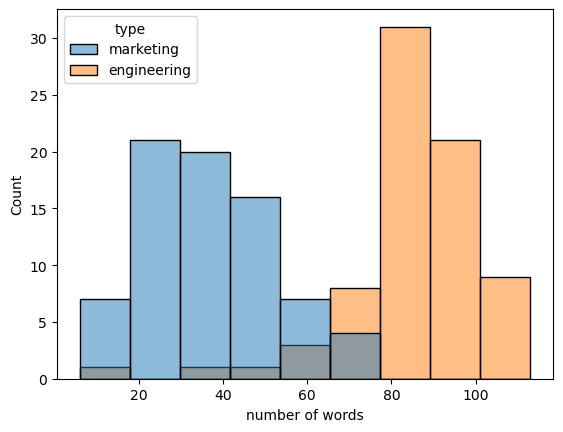

In [11]:
marketing_answers = np.array([len(list_validation_questions_answers_full[i]['gold_answer_marketing'].split()) for i in range(0, len(list_validation_questions_answers_full))])
research_answers = np.array([len(list_validation_questions_answers_full[i]['gold_answer_research'].split()) for i in range(0, len(list_validation_questions_answers_full))])
temp = (["marketing"] * len(marketing_answers)+ ['engineering'] * len(research_answers))
stats = pd.DataFrame({
    "type" : ["marketing"] * len(marketing_answers) + ['engineering'] * len(research_answers),
    "number of words" : list(marketing_answers) + list(research_answers)
})

sns.histplot(data = stats, x = "number of words", hue = 'type')

Marketing and Engineering golden answer are two different distribution

## Let setup the prompt templates

In [12]:
rag_template = PromptTemplate.from_template("""
[INST]You are a helpful assistant for question-answering tasks.
You work at a tech company that is looking for new ways to organize their question-answering and search capabilities to accelerate both engineering activity and the marketing team. The company also wants to roll out new GenAI-based products, so a lot of the questions will center around Generative AI concepts.
Please be sure to use six sentences maximum.
Your target audience is {audience}.

Answer the following question using provided context:
Context: {context}

Use the following format when you answer:

Question: {question}
Answer: <Your answer to the question>
[/INST]""")

marketing_team_rag_template = rag_template.partial(audience = "the marketing team and supporting staff who also will ask questions around GenAI in order to better understand the products and the field as a whole, but a lot more high level answers would likely be in order")
engineering_team_rag_template = rag_template.partial(audience = "the engineers, who require pretty detailed information when they ask questions")

In [13]:
output_parser = StrOutputParser()
def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)
    
def format_mistral_output(output: str) -> str:
    end_str = '[/INST]'
    idx = output.find(end_str)
    return output[idx + len(end_str) + 1:]

def format_output(output: str) -> str:
    answer_start = "Answer:"
    if answer_start not in output:
        return output
    idx = output.find(answer_start)
    return output[idx + len(answer_start) + 1:]

def get_answer_num_words(temp):
    temp = temp.strip()
    return len(temp.split())

#### Setting up chain:

In [14]:
# Marketing
marketing_cohere_rag_chain = (
    RunnablePassthrough.assign(context=(lambda x: format_docs(x["context"])))
    | marketing_team_rag_template
    | cohere_chat_model
    | output_parser | format_output
)

marketing_mistral_rag_chain = (
    RunnablePassthrough.assign(context=(lambda x: format_docs(x["context"])))
    | marketing_team_rag_template
    | mistral_llm_lc
    | output_parser
    | format_mistral_output | format_output
)


# Engineering
engineering_cohere_rag_chain = (
    RunnablePassthrough.assign(context=(lambda x: format_docs(x["context"])))
    | engineering_team_rag_template
    | cohere_chat_model
    | output_parser | format_output
)

engineering_mistral_rag_chain = (
    RunnablePassthrough.assign(context=(lambda x: format_docs(x["context"])))
    | engineering_team_rag_template
    | mistral_llm_lc
    | output_parser
    | format_mistral_output | format_output
)

## For hyperparams: CHUNKSIZE = 256, OVERLAP = 128

**Next Run at the end**

#### Passing retriever:

`CHUNKSIZE = 256, OVERLAP = 128`

In [14]:
retriever = retriever_256_128

marketing_cohere_with_sources = RunnableParallel({"context": retriever, "question": RunnablePassthrough()}).assign(answer = marketing_cohere_rag_chain)
marketing_mistral_with_sources = RunnableParallel({"context": retriever, "question": RunnablePassthrough()}).assign(answer = marketing_mistral_rag_chain)

engineering_cohere_with_sources = RunnableParallel({"context": retriever, "question": RunnablePassthrough()}).assign(answer = engineering_cohere_rag_chain)
engineering_mistral_with_sources = RunnableParallel({"context": retriever, "question": RunnablePassthrough()}).assign(answer = engineering_mistral_rag_chain)

In [13]:
marketing_mistral_with_sources.invoke(validation_questions_answers[0]["question"])

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
C:\Users\Vinh\anaconda3\envs\py-for-290\Lib\site-packages\transformers\models\mistral\modeling_mistral.py:647: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:455.)
  attn_output = torch.nn.functional.scaled_dot_product_attention(


{'context': [Document(metadata={'title': 'Language model', 'summary': 'A language model is a probabilistic model of a natural language. In 1980, the first significant statistical language model was proposed, and during the decade IBM performed ‘Shannon-style’ experiments, in which potential sources for language modeling improvement were identified by observing and analyzing the performance of human subjects in predicting or correcting text.\nLanguage models are useful for a variety of tasks, including speech recognition (helping prevent predictions of low-probability (e.g. nonsense) sequences), machine translation, natural language generation (generating more human-like text), optical character recognition, handwriting recognition, grammar induction, and information retrieval.\nLarge language models, currently their most advanced form, are a combination of larger datasets (frequently using words scraped from the public internet), feedforward neural networks, and transformers. They have

In [16]:
# Remove this when ready
list_validation_questions_answers = list_validation_questions_answers_full[:50]

golden_marketing_answers = [item['gold_answer_marketing'] for item in list_validation_questions_answers]
golden_research_answers = [item['gold_answer_research'] for item in list_validation_questions_answers]
validation_question = [item['question'] for item in list_validation_questions_answers]
len(list_validation_questions_answers)

50

#### Generate lists of LLMs responses

For marketing

In [17]:
mistral_marketing_responses = []
cohere_marketing_responses = []
for question in validation_question:
    mistral_marketing_responses.append(marketing_mistral_with_sources.invoke(question))
    cohere_marketing_responses.append(marketing_cohere_with_sources.invoke(question))

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting

For engineer research team:

In [18]:
mistral_engineering_responses = []
cohere_engineering_responses = []
for question in validation_question:
    mistral_engineering_responses.append(engineering_mistral_with_sources.invoke(question))
    cohere_engineering_responses.append(engineering_cohere_with_sources.invoke(question))

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for o

In [19]:
marketing_df = None
engineering_df = None

marketing_df = pd.DataFrame({
    "mistral" : mistral_marketing_responses,
    "cohere" : cohere_marketing_responses
})

engineering_df = pd.DataFrame({
    "mistral" : mistral_engineering_responses,
    "cohere" : cohere_engineering_responses
})

marketing_df.to_csv("./marketing_llm.csv")
engineering_df.to_csv("./engineering_llm.csv")

mistral_marketing_responses_n_words = marketing_df['mistral'].apply(lambda x: get_answer_num_words(x['answer'])).values
cohere_marketing_responses_n_words = marketing_df['cohere'].apply(lambda x: get_answer_num_words(x['answer'])).values
mistral_engineering_responses_n_words = engineering_df['mistral'].apply(lambda x: get_answer_num_words(x['answer'])).values
cohere_engineering_responses_n_words = engineering_df['cohere'].apply(lambda x: get_answer_num_words(x['answer'])).values

Text(0.5, 1.0, 'Marketing')

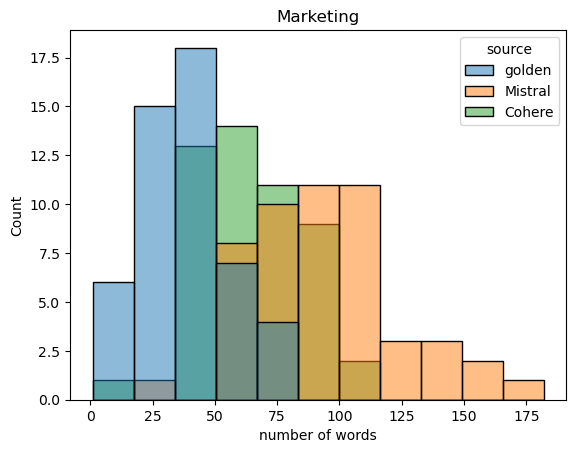

In [22]:
n = len(list_validation_questions_answers)
marketing_num_words = pd.DataFrame({
    "source" : ['golden'] * n + ["Mistral"] * n + ["Cohere"] * n,
    "number of words" : list(marketing_answers[:50]) + list(mistral_marketing_responses_n_words) + list(cohere_marketing_responses_n_words)
})

sns.histplot(data = marketing_num_words, x="number of words", hue = 'source').set_title("Marketing")

Text(0.5, 1.0, 'Engineering')

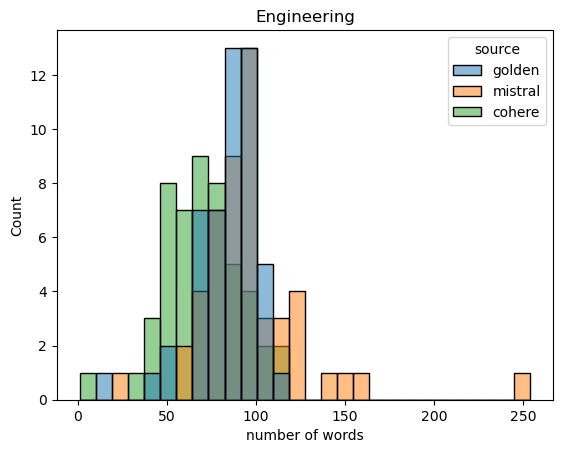

In [23]:
n = len(list_validation_questions_answers)
engineering_num_words = pd.DataFrame({
    "source" : ["golden"] * n + ['mistral'] * n + ['cohere'] * n,
    "number of words" : list(research_answers[:50]) + list(mistral_engineering_responses_n_words) + list(cohere_engineering_responses_n_words)
})

sns.histplot(data = engineering_num_words, x="number of words", hue = 'source').set_title("Engineering")

## 4. Tests & Evaluations

Here you should evaluate the results. First, you should define your evaluation metrics and then you should run evaluation tests. This is really your area, but key results to show are:

1) Your metrics of choice  
2) How  your various models compare to the labeled validation data.

Make sure you look at the results for the marketing team and the research team separately.

**Note:** You do not need to run all models against all labeled questions, as that may take some time. Just do that for a few models/configs, and test a larger set with a smaller subset.

**This is free form so you will need to create your own cells, text documentation as you need, etc.**

### 4.1. Metrics

Please define and motivate your metrics here. Please feel free to add more text and code cells as needed.



To assess the performance of large language models (LLMs), multiple evaluation metrics will be used, which are three distinct categories of metrics:

N-gram based: Leveraging established metrics like ROUGE and BLEU, we will conduct a fine-grained analysis of n-gram overlap between LLM-generated responses and gold-standard references. This approach allows for the quantification of lexical and phrasal alignment.

Semantic Similarity: Employing sentence transformer models, we will encode responses into dense vector representations. Cosine similarity between these vectors will serve as a proxy for semantic alignment, capturing nuanced differences in meaning that may not be evident at the n-gram level.

LLM-based Evaluation: In a novel approach, we will leverage the discriminatory power of LLMs themselves. Mistral and Cohere models will be tasked with evaluating responses generated by their peers, using a Likert scale from 1 (worst) to 5 (best). This blind evaluation will provide insights into the perceived quality of responses from the perspective of state-of-the-art language models.

Ragas is an open-source project that encapsulate some of the important metrics into it.

#### N-grams setup

In this approach, I will use novel BLEU and ROUGE as metrics for comparison

In [15]:
bleu = classic_eval.load('bleu')
rouge = classic_eval.load('rouge')

#### Sementic setup

I will use `multi-qa-mpnet-base-dot-v1` to transform the golden answers and responses from LLMs to transform them into vectors, then apply consine similarity to compare how close they are.

In [16]:
evaluator_embedding = base_embeddings
from numpy.linalg import norm

def consine_calculation(X, Y):
    X = np.array(X)
    Y = np.array(Y)
    return np.dot(X, Y) / (norm(X) * norm(Y))

#### LLM as a judge

In this approach, I will setup GPT3.5-turbo to judge which response is closer to the golden answers. We will count to see which model has more better number of responses.

In [17]:
model_name = "gpt-3.5-turbo"
openai_model = ChatOpenAI(model=model_name, temperature=0.1, api_key=OPENAI_API_KEY, max_tokens=150)

judge_prompt = PromptTemplate.from_template(""" You are LLM expert.
You will act as a judge to decide which responses are more similar to the golden answer. You only need to response with the model's name. Keep your answer concise. There are only two acceptable outputs: cohere or mistral. Here is the information:
Golden answer: {golden_answer}
Model Mistral: {mistral}
Model cohere: {cohere}
""")

scoring_prompt = PromptTemplate.from_template(""" You are LLM expert.
You will score from 1 to 10 how well ai response similar to golden answer. 10 is most similar, 1 is the worst similar. Before giving answer, provide your reasoning concisely. Here is the information:
Golden answer: {golden_answer}
AI Reponse: {ai_response}

Please use the following format:
**Reasoning** : Your concise reasons here
**Score** : the final score
""")

In [18]:
answer_mistral_marketing = [res['answer'] for res in mistral_marketing_responses]
answer_cohere_marketing = [res['answer'] for res in cohere_marketing_responses]

answer_mistral_engineering = [res['answer'] for res in mistral_engineering_responses]
answer_cohere_engineering = [res['answer'] for res in cohere_engineering_responses]

NameError: name 'mistral_marketing_responses' is not defined

### 4.2. Evaluation Comparisons

**N-Grams**

In [28]:
# Marketing
bleu_marketing_mistral = bleu.compute(predictions = answer_mistral_marketing, references = golden_marketing_answers)
bleu_marketing_cohere = bleu.compute(predictions = answer_cohere_marketing, references = golden_marketing_answers)
rouge_marketing_mistral = rouge.compute(predictions = answer_mistral_marketing, references = golden_marketing_answers)
rouge_marketing_cohere = rouge.compute(predictions = answer_cohere_marketing, references = golden_marketing_answers)

# Engeering
bleu_engineering_mistral = bleu.compute(predictions = answer_mistral_engineering, references = golden_research_answers)
bleu_engineering_cohere = bleu.compute(predictions =answer_cohere_engineering, references = golden_research_answers)
rouge_engineering_mistral = rouge.compute(predictions = answer_mistral_engineering, references = golden_research_answers)
rouge_engineering_cohere = rouge.compute(predictions = answer_cohere_engineering, references = golden_research_answers)

# Printing
print("--Marketing:")
print("Mistral")
print(bleu_marketing_mistral)
print(rouge_marketing_mistral)
print("Cohere")
print(bleu_marketing_cohere)
print(rouge_marketing_cohere)

print("\n=============================\n")

print("--Engineering")
print("Mistral")
print(bleu_engineering_mistral)
print(rouge_engineering_mistral)
print("Cohere")
print(bleu_engineering_cohere)
print(rouge_engineering_cohere)

--Marketing:
Mistral
{'bleu': 0.05599526042291253, 'precisions': [0.1991411701556629, 0.06643798519588373, 0.034250318819457094, 0.02169516455230741], 'brevity_penalty': 1.0, 'length_ratio': 2.615348619560131, 'translation_length': 5589, 'reference_length': 2137}
{'rouge1': 0.2882412041161132, 'rouge2': 0.11419913013975266, 'rougeL': 0.2063854621500571, 'rougeLsum': 0.20821695162816134}
Cohere
{'bleu': 0.06048416965561909, 'precisions': [0.2598382749326146, 0.08278688524590164, 0.03573407202216067, 0.017410839651783208], 'brevity_penalty': 1.0, 'length_ratio': 1.736078614880674, 'translation_length': 3710, 'reference_length': 2137}
{'rouge1': 0.3056030716313164, 'rouge2': 0.10485836306169033, 'rougeL': 0.21227512809403304, 'rougeLsum': 0.21269809364542264}


--Engineering
Mistral
{'bleu': 0.07439028773420882, 'precisions': [0.3252310852447792, 0.09927486187845304, 0.04319052594914664, 0.02196064652143359], 'brevity_penalty': 1.0, 'length_ratio': 1.2566143256614326, 'translation_length'

#### Sementic Search

Here we will use `multi-qa-mpnet-base-dot-v1` to transform the golden answers and llm's responses to vectors, and use cosine similarity to calculate how close they are.

In [29]:
# Transform golden answers to vectors
golden_marketing_answers_vectors = evaluator_embedding.embed_documents(golden_marketing_answers)
golden_engineering_answers_vectors = evaluator_embedding.embed_documents(golden_research_answers)

# Transform llm's responses to vectors

## Marketing
mistral_marketing_response_vectors = evaluator_embedding.embed_documents(answer_mistral_marketing)
cohere_marketing_response_vectors = evaluator_embedding.embed_documents(answer_cohere_marketing)

## Engineering
mistral_engineering_response_vectors = evaluator_embedding.embed_documents(answer_mistral_engineering)
cohere_engineering_response_vectors = evaluator_embedding.embed_documents(answer_cohere_engineering)

cosine_df = pd.DataFrame({
    "golden_marketing" : golden_marketing_answers_vectors,
    "golden_engineering" : golden_engineering_answers_vectors,
    "mistral_marketing_vector" : mistral_marketing_response_vectors,
    "mistral_engineering_vector" : mistral_engineering_response_vectors,
    "cohere_marketing_vector" : cohere_marketing_response_vectors,
    "cohere_engineering_vector" : cohere_engineering_response_vectors
})

cosine_df['mistral_marketing_cosine'] = cosine_df.apply(lambda x: consine_calculation(x["golden_marketing"], x["mistral_marketing_vector"]), axis=1)
cosine_df['cohere_marketing_cosine'] = cosine_df.apply(lambda x: consine_calculation(x["golden_marketing"], x["cohere_marketing_vector"]), axis=1)
cosine_df['mistral_engineering_cosine'] = cosine_df.apply(lambda x: consine_calculation(x["golden_engineering"], x["mistral_engineering_vector"]), axis=1)
cosine_df['cohere_engineering_cosine'] = cosine_df.apply(lambda x: consine_calculation(x["golden_engineering"], x["cohere_engineering_vector"]), axis=1)

print(f"MARKETING: Consine similarity between mistral vs. golden answer {cosine_df['mistral_marketing_cosine'].mean()}")
print(f"MARKETING: Consine similarity between cohere vs. golden answer {cosine_df['cohere_marketing_cosine'].mean()}")
print(f"ENGINEERING: Consine similarity between mistral vs. golden answer {cosine_df['mistral_engineering_cosine'].mean()}")
print(f"ENGINEERING: Consine similarity between cohere vs. golden answer {cosine_df['cohere_engineering_cosine'].mean()}")

MARKETING: Consine similarity between mistral vs. golden answer 0.7535734524902581
MARKETING: Consine similarity between cohere vs. golden answer 0.7557168697522308
ENGINEERING: Consine similarity between mistral vs. golden answer 0.760160251965881
ENGINEERING: Consine similarity between cohere vs. golden answer 0.7818919176172802


#### LLM as a judge


In [30]:
def calculate_judge_stats(golden_answers, mistral_responses, cohere_responses):
    judges = []
    for i in range(len(golden_answers)):
        golden_answer = golden_answers[i]
        mistral_response = mistral_responses[i]
        cohere_response = cohere_responses[i]
        response = openai_model.invoke(judge_prompt.invoke({
        "golden_answer" : golden_answer,
        "mistral" : mistral_response,
        "cohere" : cohere_response
        }))

        if "cohere" in response.content.lower():
            judges.append(1)
        elif "mistral" in response.content.lower():
            judges.append(0)
        else:
            print(response.content)
    return judges

# Marketing - value encoded as 1 if cohere wins, 0 otherwise
marketing_judge_stat = calculate_judge_stats(golden_marketing_answers, answer_mistral_marketing, answer_cohere_marketing)
# Engineering - value encoded as 1 if cohere wins, 0 otherwise
engineering_judge_stat = calculate_judge_stats(golden_research_answers, answer_mistral_engineering, answer_cohere_engineering)

print("MARKETING")
print(f"Cohere preferred: {np.sum(marketing_judge_stat)}")
print(f"Mistral preferred: {len(marketing_judge_stat) - np.sum(marketing_judge_stat)}")
print("==========================")
print("ENGINEERING")
print(f"Cohere preferred: {np.sum(engineering_judge_stat)}")
print(f"Mistral preferred: {len(engineering_judge_stat) - np.sum(engineering_judge_stat)}")
print("==========================")

MARKETING
Cohere preferred: 44
Mistral preferred: 6
ENGINEERING
Cohere preferred: 47
Mistral preferred: 3


#### USING RAGAS

In [ ]:
metrics = [faithfulness, answer_relevancy]

contexts = list()
for response in mistral_marketing_responses:
    context = [c.page_content for c in response["context"]]
    contexts.append(context)

mistral_marketing_dataset = Dataset.from_dict({
    "question" : validation_question,
    "answer" : answer_mistral_marketing,
    "contexts" : contexts,
    "ground_truths" : golden_marketing_answers
})

cohere_marketing_dataset = Dataset.from_dict({
    "question" : validation_question,
    "answer" : answer_cohere_marketing,
    "contexts" : contexts,
    "ground_truths" : golden_marketing_answers
})

mistral_engineering_dataset = Dataset.from_dict({
    "question" : validation_question,
    "answer" : answer_mistral_engineering,
    "contexts" : contexts,
    "ground_truths" : golden_research_answers
})

cohere_engineering_dataset = Dataset.from_dict({
    "question" : validation_question,
    "answer" : answer_cohere_engineering,
    "contexts" : contexts,
    "ground_truths" : golden_research_answers
})


eval_result_mistral_marketing = evaluate(dataset=mistral_marketing_dataset, metrics=metrics)
eval_result_cohere_marketing = evaluate(dataset=cohere_marketing_dataset, metrics=metrics)



In [32]:
eval_result_mistral_engineering = evaluate(dataset=mistral_engineering_dataset, metrics=metrics)
eval_result_cohere_engineering = evaluate(dataset=cohere_engineering_dataset, metrics=metrics)

print(f"Mistral Marketing answeer: {eval_result_mistral_marketing}")
print(f"Cohere Marketing answeer: {eval_result_cohere_marketing}")
print(f"Mistral Engineering answeer: {eval_result_mistral_engineering}")
print(f"Cohere Engineering answeer: {eval_result_cohere_engineering}")

Evaluating:   0%|          | 0/100 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/100 [00:00<?, ?it/s]

Mistral Marketing answeer: {'faithfulness': 0.7327, 'answer_relevancy': 0.8685}
Cohere Marketing answeer: {'faithfulness': 0.6125, 'answer_relevancy': 0.8733}
Mistral Engineering answeer: {'faithfulness': 0.6802, 'answer_relevancy': 0.8303}
Cohere Engineering answeer: {'faithfulness': 0.6745, 'answer_relevancy': 0.9267}


## 5. Results

### 5.1 Model Specifications

Document the detailed specs of your choices. Also comment on how you valued the needs of the marketing tean vs the needs of the researchers, in case you had to make a trade-off.


Cohere performs equally in some metrics and outperforms mistral other metrics, so I decide to use cohere model. Text spliting with chunk size 512, and overlapping 256.


### 5.2 Some Test Questions

**QUESTIONS:**


Please study the answers generated by your chosen setup for these specific test questions:

1. "What purpose do large language models serve in the field of natural language processing?" (Question 0)

2. "What methods are typically employed to create training data for embedding models that use task-specific instructions?" (Question 50)

3. "How does a model's ability to answer questions relate to its exposure to specific types of questions during training?" (Question 83, no labeled answers)

For each of the three questions above please provide:

a) The RAG results (research and marketing response)  
b) The context provided  
c) The document sources for the context  
d) Also discuss your metric(s) for the first two examples (for both responses) compared to the gold responses

Then, for questions 1 and 2, comment on how well you feel your metrics captured the differences and similarities between your answer and the gold answer?

Put your answers to these questions into the answers file as you have done on previous assignments. Please consult the answer file for further details.

#### 5.2.1 Test Question 1

Please run the query:








In [124]:
engineering_df.iloc[0]['cohere']

{'context': [Document(metadata={'title': 'Language model', 'summary': 'A language model is a probabilistic model of a natural language. In 1980, the first significant statistical language model was proposed, and during the decade IBM performed ‘Shannon-style’ experiments, in which potential sources for language modeling improvement were identified by observing and analyzing the performance of human subjects in predicting or correcting text.\nLanguage models are useful for a variety of tasks, including speech recognition (helping prevent predictions of low-probability (e.g. nonsense) sequences), machine translation, natural language generation (generating more human-like text), optical character recognition, handwriting recognition, grammar induction, and information retrieval.\nLarge language models, currently their most advanced form, are a combination of larger datasets (frequently using words scraped from the public internet), feedforward neural networks, and transformers. They have

In [125]:
marketing_df.iloc[0]['cohere']

{'context': [Document(metadata={'title': 'Language model', 'summary': 'A language model is a probabilistic model of a natural language. In 1980, the first significant statistical language model was proposed, and during the decade IBM performed ‘Shannon-style’ experiments, in which potential sources for language modeling improvement were identified by observing and analyzing the performance of human subjects in predicting or correcting text.\nLanguage models are useful for a variety of tasks, including speech recognition (helping prevent predictions of low-probability (e.g. nonsense) sequences), machine translation, natural language generation (generating more human-like text), optical character recognition, handwriting recognition, grammar induction, and information retrieval.\nLarge language models, currently their most advanced form, are a combination of larger datasets (frequently using words scraped from the public internet), feedforward neural networks, and transformers. They have

In [126]:
golden_research_answers[0]

'Large language models (LLMs) serve the purpose of enabling general-purpose language generation and other natural language processing tasks such as classification. They achieve this by learning statistical relationships from text documents during computationally intensive self-supervised and semi-supervised training. LLMs can be used for text generation by predicting the next token or word, making them valuable for tasks like speech recognition, machine translation, and information retrieval. Additionally, LLMs have superseded previous models like recurrent neural networks, showcasing their efficiency and effectiveness in NLP tasks.'

In [127]:
golden_marketing_answers[0]

'Large language models serve the purpose of improving performance in various natural language processing tasks, such as speech recognition, machine translation, natural language generation, optical character recognition, handwriting recognition, grammar induction, and information retrieval.'

In [128]:
question_index = 0
# BLEU
print("============ BLEU ============")
engineering_cohere_q1 = 'Large Language Models (LLMs) are a pivotal advancement in Natural Language Processing (NLP). They combine vast datasets, feedforward neural networks, and transformers to offer a range of capabilities, from speech recognition to natural language generation. With their ability to process and generate human-like text, LLMs have become the cornerstone for building advanced AI applications, offering a more nuanced understanding of language and enabling a new generation of AI products.'
print(f"Engineering: {bleu.compute(predictions = [engineering_cohere_q1], references=[golden_research_answers[question_index]])}")

marketing_cohere_q1 = 'Large language models are an essential advancement in natural language processing (NLP). They enable machines to understand and generate human-like text, with applications in speech recognition, machine translation, and text generation. These models use vast datasets and advanced neural networks to surpass previous models in accuracy and flexibility. The marketing team can utilize this technology to create more effective content and strategies, enhancing their understanding of target audiences and improving communication. However, it is crucial to address the potential risks of bias and privacy breaches that come with this powerful technology.'
print(f"Marketing: {bleu.compute(predictions = [marketing_cohere_q1], references=[golden_marketing_answers[question_index]])}")

# ROUGE
print("\n============ ROUGE ============")
print(f"Engineering: {rouge.compute(predictions = [engineering_cohere_q1], references=[golden_research_answers[question_index]])}")
print(f"Marketing: {rouge.compute(predictions = [marketing_cohere_q1], references=[golden_marketing_answers[0]])}")

# Semantic
print("\n============ SEMANTIC ============")
print(f"Engineering: {consine_calculation(evaluator_embedding.embed_documents([golden_research_answers[question_index]]), evaluator_embedding.embed_query(engineering_cohere_q1))}")
print(f"Marketing: {consine_calculation(evaluator_embedding.embed_documents([golden_marketing_answers[question_index]]), evaluator_embedding.embed_query(marketing_cohere_q1))}")

# LLM as a judge
print("\n============ LLM as a judge ============")
openai_score = openai_model.invoke(scoring_prompt.invoke({"golden_answer" : golden_research_answers[question_index], "ai_response": engineering_cohere_q1})).content
print(f"Engineering {openai_score}")
openai_score = openai_model.invoke(scoring_prompt.invoke({"golden_answer" : golden_marketing_answers[question_index], "ai_response": marketing_cohere_q1})).content
print(f"Marketing {openai_score}")


============ BLEU ============
Engineering: {'bleu': 0.0, 'precisions': [0.4444444444444444, 0.1375, 0.0379746835443038, 0.0], 'brevity_penalty': 0.8517230811056075, 'length_ratio': 0.8617021276595744, 'translation_length': 81, 'reference_length': 94}
Marketing: {'bleu': 0.07815991959090349, 'precisions': [0.21359223300970873, 0.09803921568627451, 0.0594059405940594, 0.03], 'brevity_penalty': 1.0, 'length_ratio': 2.4523809523809526, 'translation_length': 103, 'reference_length': 42}

============ ROUGE ============
Engineering: {'rouge1': 0.38461538461538464, 'rouge2': 0.1168831168831169, 'rougeL': 0.19230769230769232, 'rougeLsum': 0.19230769230769232}
Marketing: {'rouge1': 0.25396825396825395, 'rouge2': 0.11290322580645164, 'rougeL': 0.20634920634920634, 'rougeLsum': 0.20634920634920634}

============ SEMANTIC ============
Engineering: [0.92657042]
Marketing: [0.80712411]

============ LLM as a judge ============
Engineering **Reasoning** : The AI response captures the essence of LLMs

In [156]:
eval_result_cohere_engineering.to_pandas().iloc[0]

question            What purpose do large language models serve in...
answer              Large language models (LLMs) are a pivotal too...
contexts            [Language models are useful for a variety of t...
ground_truths       Large language models (LLMs) serve the purpose...
faithfulness                                                    0.875
answer_relevancy                                             0.914851
Name: 0, dtype: object

In [157]:
eval_result_cohere_marketing.to_pandas().iloc[0]

question            What purpose do large language models serve in...
answer              Large Language Models (LLMs) are a powerful to...
contexts            [Language models are useful for a variety of t...
ground_truths       Large language models serve the purpose of imp...
faithfulness                                                 0.714286
answer_relevancy                                             0.923163
Name: 0, dtype: object

##### Discussion

BLEU and ROUGE are both n-grams based metric. Therefore, if the LLM generated a different vocabulary or more length, it does not capture the different well. Also, if we look at the marketing cohere generated answer, it writes a little about bias and privacy which is, in my opinion, crucial for marketing team.

The semantic in the other hand, capturing well how similar the answer is to the golden answer.

LLM as a judge: This approach is different, use `chatgpt3.5`, which I assume that it performs better than cohere. We could have more accurate result if we could use chatgpt4, but due to the budget, we stick with 3.5. However, as we can see, the answer from GPT3.5 is simiar to cosine similarity comparision, which engineering answer is better than marketing answer.

#### 5.2.2 Test Question 2

Please run the query:

In [130]:
sample_50 = {"question": "What methods are typically employed to create training data for embedding models that use task-specific instructions?",
  "gold_answer_research": "To create training data for embedding models that use task-specific instructions, a common method is to combine datasets from different sources, such as the SuperNaturalInstructions dataset with existing collections designed for embedding training. The SuperNaturalInstructions dataset provides natural language instructions, which can be paired with positive and negative examples to form training samples. Additionally, for tasks like classification or similarity, training samples can be constructed by selecting text sequences associated with different classes or similarities. This diverse training data is essential for instruction-based finetuning, which enables the embedding model to learn from a wide range of tasks and domains.",
  "gold_answer_marketing": "Training data for embedding models that use task-specific instructions is typically created by formulating a wide variety of tasks as text-to-text problems, distinguishing good/bad candidate outputs given an input text. This is done by combining datasets with natural language instructions and constructing positive and negative pairs for training."}

In [135]:
q2_engineering = engineering_cohere_with_sources.invoke(sample_50['question'])


In [136]:
q2_marketing = marketing_cohere_with_sources.invoke(sample_50['question'])

In [150]:
q2_engineering['answer']

'Training data for embedding models that employ task-specific instructions is typically synthesized using a data synthesis framework. This involves creating a diverse collection of datasets with instructions across various task categories and domains. In the given context, the authors construct the MEDI dataset, which contains 330 datasets with instructions for multitask embedding training. This approach enables the model to learn task-specific representations and adapt to different downstream tasks.'

In [151]:
q2_marketing['answer']

'One common method for creating training data for embedding models that utilize task-specific instructions is to construct large-scale datasets with diverse task categories and domains. This approach, as seen with MEDI, helps the model understand a wide range of instructions and contexts, improving performance on various downstream tasks. Additionally, synthetic data generation, as mentioned in the context, can be used to efficiently create diverse and fine-grained instruction-following training data.'

In [152]:
q2_marketing['context']

[Document(metadata={'source': 'https://arxiv.org/pdf/2212.09741.pdf', 'file_path': 'https://arxiv.org/pdf/2212.09741.pdf', 'page': 1, 'total_pages': 18, 'format': 'PDF 1.5', 'title': '', 'author': '', 'subject': '', 'keywords': '', 'creator': 'LaTeX with hyperref', 'producer': 'pdfTeX-1.40.25', 'creationDate': 'D:20230531004557Z', 'modDate': 'D:20230531004557Z', 'trapped': '', 'page_num': 1, 'doc_num': 9, 'doc_source': 'ArXiv', 'split_id': 5634, '_id': '25eb261825f94000aa6fa492df80514f', '_collection_name': 'rag_tech_db'}, page_content='performs prior state-of-the-art embedding models\nby an average of 3.4% over the 70 diverse datasets.\nINSTRUCTOR also outperforms a variant that is\ntrained without task instructions (§4), demonstrat-\ning the importance of instructions to create task-'),
 Document(metadata={'source': 'https://arxiv.org/pdf/2212.09741.pdf', 'file_path': 'https://arxiv.org/pdf/2212.09741.pdf', 'page': 2, 'total_pages': 18, 'format': 'PDF 1.5', 'title': '', 'author': '',

In [145]:
# BLEU
print("============ BLEU ============")
print(f"Engineering: {bleu.compute(predictions = [q2_engineering['answer']], references=[sample_50['gold_answer_research']])}")
print(f"Marketing: {bleu.compute(predictions = [q2_marketing['answer']], references=[sample_50['gold_answer_marketing']])}")

# ROUGE
print("\n============ ROUGE ============")
print(f"Engineering: {rouge.compute(predictions = [q2_engineering['answer']], references=[sample_50['gold_answer_research']])}")
print(f"Marketing: {rouge.compute(predictions = [q2_marketing['answer']], references=[sample_50['gold_answer_marketing']])}")

# Semantic
print("\n============ SEMANTIC ============")
print(f"Engineering: {consine_calculation(evaluator_embedding.embed_documents([sample_50['gold_answer_research']]), evaluator_embedding.embed_query(q2_engineering['answer']))}")
print(f"Marketing: {consine_calculation(evaluator_embedding.embed_documents([sample_50['gold_answer_marketing']]), evaluator_embedding.embed_query(q2_marketing['answer']))}")

# LLM as a judge
print("\n============ LLM as a judge ============")
openai_score = openai_model.invoke(scoring_prompt.invoke({"golden_answer" : sample_50["gold_answer_research"], "ai_response": q2_engineering['answer']})).content
print(f"Engineering {openai_score}")
openai_score = openai_model.invoke(scoring_prompt.invoke({"golden_answer" : sample_50["gold_answer_marketing"], "ai_response": q2_marketing["answer"]})).content
print(f"Marketing {openai_score}")


============ BLEU ============
Engineering: {'bleu': 0.07831183060932587, 'precisions': [0.5540540540540541, 0.1917808219178082, 0.08333333333333333, 0.028169014084507043], 'brevity_penalty': 0.623146912758521, 'length_ratio': 0.6788990825688074, 'translation_length': 74, 'reference_length': 109}
Marketing: {'bleu': 0.08653867896394793, 'precisions': [0.3076923076923077, 0.12987012987012986, 0.05263157894736842, 0.02666666666666667], 'brevity_penalty': 1.0, 'length_ratio': 1.471698113207547, 'translation_length': 78, 'reference_length': 53}

============ ROUGE ============
Engineering: {'rouge1': 0.4444444444444444, 'rouge2': 0.14201183431952663, 'rougeL': 0.29239766081871343, 'rougeLsum': 0.29239766081871343}
Marketing: {'rouge1': 0.384, 'rouge2': 0.1788617886178862, 'rougeL': 0.288, 'rougeLsum': 0.288}

============ SEMANTIC ============
Engineering: [0.70921419]
Marketing: [0.81011689]

============ LLM as a judge ============
Engineering **Reasoning** : The AI response discusses th

In [207]:
eval_result_cohere_engineering.to_pandas().iloc[35]

question            What methods are typically employed to create ...
answer              Training data for embedding models that employ...
contexts            [performs prior state-of-the-art embedding mod...
ground_truths       To create training data for embedding models t...
faithfulness                                                      1.0
answer_relevancy                                             0.907295
Name: 35, dtype: object

In [209]:
eval_result_cohere_marketing.to_pandas().iloc[35]

question            What methods are typically employed to create ...
answer              One common method for creating training data f...
contexts            [performs prior state-of-the-art embedding mod...
ground_truths       Training data for embedding models that use ta...
faithfulness                                                      1.0
answer_relevancy                                             0.982949
Name: 35, dtype: object

#### 5.2.3 Test Question 3

Please run the query:

In [146]:
question_83 = "How does a model's ability to answer questions relate to its exposure to specific types of questions during training?"


In [147]:
answer_83 = engineering_cohere_with_sources.invoke(question_83)
print(answer_83)

{'context': [Document(metadata={'source': 'https://lilianweng.github.io/posts/2020-10-29-odqa/', 'doc_num': 27, 'doc_source': 'WWW', 'split_id': 16, '_id': '08fb4a21b1fa4d588968c3dd0d5576fb', '_collection_name': 'rag_tech_db'}, page_content='A model is able to correctly memorize and respond with the answer to a question that has been seen at training time.\nA model is able to answer novel questions at test time and choose an answer from the set of answers it has seen during training.'), Document(metadata={'source': 'https://lilianweng.github.io/posts/2020-10-29-odqa/', 'doc_num': 27, 'doc_source': 'WWW', 'split_id': 17, '_id': 'a4facb0eee7349c6a5f2fb6110163caf', '_collection_name': 'rag_tech_db'}, page_content='A model is able to answer novel questions which have answers not contained in the training dataset.'), Document(metadata={'source': 'https://arxiv.org/pdf/2310.11511.pdf', 'file_path': 'https://arxiv.org/pdf/2310.11511.pdf', 'page': 19, 'total_pages': 30, 'format': 'PDF 1.5', 't

In [148]:
answer_83 = marketing_cohere_with_sources.invoke(question_83)
print(answer_83)

{'context': [Document(metadata={'source': 'https://lilianweng.github.io/posts/2020-10-29-odqa/', 'doc_num': 27, 'doc_source': 'WWW', 'split_id': 16, '_id': '08fb4a21b1fa4d588968c3dd0d5576fb', '_collection_name': 'rag_tech_db'}, page_content='A model is able to correctly memorize and respond with the answer to a question that has been seen at training time.\nA model is able to answer novel questions at test time and choose an answer from the set of answers it has seen during training.'), Document(metadata={'source': 'https://lilianweng.github.io/posts/2020-10-29-odqa/', 'doc_num': 27, 'doc_source': 'WWW', 'split_id': 17, '_id': 'a4facb0eee7349c6a5f2fb6110163caf', '_collection_name': 'rag_tech_db'}, page_content='A model is able to answer novel questions which have answers not contained in the training dataset.'), Document(metadata={'source': 'https://arxiv.org/pdf/2310.11511.pdf', 'file_path': 'https://arxiv.org/pdf/2310.11511.pdf', 'page': 19, 'total_pages': 30, 'format': 'PDF 1.5', 't

In [153]:
answer_83["context"]

[Document(metadata={'source': 'https://lilianweng.github.io/posts/2020-10-29-odqa/', 'doc_num': 27, 'doc_source': 'WWW', 'split_id': 16, '_id': '08fb4a21b1fa4d588968c3dd0d5576fb', '_collection_name': 'rag_tech_db'}, page_content='A model is able to correctly memorize and respond with the answer to a question that has been seen at training time.\nA model is able to answer novel questions at test time and choose an answer from the set of answers it has seen during training.'),
 Document(metadata={'source': 'https://lilianweng.github.io/posts/2020-10-29-odqa/', 'doc_num': 27, 'doc_source': 'WWW', 'split_id': 17, '_id': 'a4facb0eee7349c6a5f2fb6110163caf', '_collection_name': 'rag_tech_db'}, page_content='A model is able to answer novel questions which have answers not contained in the training dataset.'),
 Document(metadata={'source': 'https://arxiv.org/pdf/2310.11511.pdf', 'file_path': 'https://arxiv.org/pdf/2310.11511.pdf', 'page': 19, 'total_pages': 30, 'format': 'PDF 1.5', 'title': '',

Discuss...

## Combine all calculation into function

In [19]:
import time

def calculate_judge_stats(golden_answers, mistral_responses, cohere_responses):
    judges = []
    for i in range(len(golden_answers)):
        golden_answer = golden_answers[i]
        mistral_response = mistral_responses[i]
        cohere_response = cohere_responses[i]
        response = openai_model.invoke(judge_prompt.invoke({
        "golden_answer" : golden_answer,
        "mistral" : mistral_response,
        "cohere" : cohere_response
        }))

        if "cohere" in response.content.lower():
            judges.append(1)
        elif "mistral" in response.content.lower():
            judges.append(0)
        else:
            print(response.content)
    return judges

def test_with_retriever(retriever, list_validation_questions_answers):
    golden_marketing_answers = [item['gold_answer_marketing'] for item in list_validation_questions_answers]
    golden_research_answers = [item['gold_answer_research'] for item in list_validation_questions_answers]
    validation_question = [item['question'] for item in list_validation_questions_answers]
    marketing_cohere_with_sources = RunnableParallel({"context": retriever, "question": RunnablePassthrough()}).assign(answer = marketing_cohere_rag_chain)
    marketing_mistral_with_sources = RunnableParallel({"context": retriever, "question": RunnablePassthrough()}).assign(answer = marketing_mistral_rag_chain)
    
    engineering_cohere_with_sources = RunnableParallel({"context": retriever, "question": RunnablePassthrough()}).assign(answer = engineering_cohere_rag_chain)
    engineering_mistral_with_sources = RunnableParallel({"context": retriever, "question": RunnablePassthrough()}).assign(answer = engineering_mistral_rag_chain)
    
    print("======= Collecting responses from Mistral and Cohere")
    print("=== Marketing ===")
    mistral_marketing_responses = []
    cohere_marketing_responses = []
    for question in validation_question:
        mistral_marketing_responses.append(marketing_mistral_with_sources.invoke(question))
        cohere_marketing_responses.append(marketing_cohere_with_sources.invoke(question))
        time.sleep(2)
    print("=== Engineering ===")
    mistral_engineering_responses = []
    cohere_engineering_responses = []
    for question in validation_question:
        mistral_engineering_responses.append(engineering_mistral_with_sources.invoke(question))
        cohere_engineering_responses.append(engineering_cohere_with_sources.invoke(question))
        time.sleep(2)

    marketing_df = None
    engineering_df = None
    
    marketing_df = pd.DataFrame({
        "mistral" : mistral_marketing_responses,
        "cohere" : cohere_marketing_responses
    })
    
    engineering_df = pd.DataFrame({
        "mistral" : mistral_engineering_responses,
        "cohere" : cohere_engineering_responses
    })
    
    answer_mistral_marketing = [res['answer'] for res in mistral_marketing_responses]
    answer_cohere_marketing = [res['answer'] for res in cohere_marketing_responses]
    answer_mistral_engineering = [res['answer'] for res in mistral_engineering_responses]
    answer_cohere_engineering = [res['answer'] for res in cohere_engineering_responses]

    # Marketing
    bleu_marketing_mistral = bleu.compute(predictions = answer_mistral_marketing, references = golden_marketing_answers)
    bleu_marketing_cohere = bleu.compute(predictions = answer_cohere_marketing, references = golden_marketing_answers)
    rouge_marketing_mistral = rouge.compute(predictions = answer_mistral_marketing, references = golden_marketing_answers)
    rouge_marketing_cohere = rouge.compute(predictions = answer_cohere_marketing, references = golden_marketing_answers)
    
    # Engeering
    bleu_engineering_mistral = bleu.compute(predictions = answer_mistral_engineering, references = golden_research_answers)
    bleu_engineering_cohere = bleu.compute(predictions =answer_cohere_engineering, references = golden_research_answers)
    rouge_engineering_mistral = rouge.compute(predictions = answer_mistral_engineering, references = golden_research_answers)
    rouge_engineering_cohere = rouge.compute(predictions = answer_cohere_engineering, references = golden_research_answers)
    
    # Printing
    print("--Marketing:")
    print("Mistral")
    print(bleu_marketing_mistral)
    print(rouge_marketing_mistral)
    print("Cohere")
    print(bleu_marketing_cohere)
    print(rouge_marketing_cohere)
    print("\n=============================\n")
    print("--Engineering")
    print("Mistral")
    print(bleu_engineering_mistral)
    print(rouge_engineering_mistral)
    print("Cohere")
    print(bleu_engineering_cohere)
    print(rouge_engineering_cohere)
    print('\n')

    # Transform golden answers to vectors
    golden_marketing_answers_vectors = evaluator_embedding.embed_documents(golden_marketing_answers)
    golden_engineering_answers_vectors = evaluator_embedding.embed_documents(golden_research_answers)
    
    # Transform llm's responses to vectors
    
    ## Marketing
    mistral_marketing_response_vectors = evaluator_embedding.embed_documents(answer_mistral_marketing)
    cohere_marketing_response_vectors = evaluator_embedding.embed_documents(answer_cohere_marketing)
    
    ## Engineering
    mistral_engineering_response_vectors = evaluator_embedding.embed_documents(answer_mistral_engineering)
    cohere_engineering_response_vectors = evaluator_embedding.embed_documents(answer_cohere_engineering)
    
    cosine_df = pd.DataFrame({
        "golden_marketing" : golden_marketing_answers_vectors,
        "golden_engineering" : golden_engineering_answers_vectors,
        "mistral_marketing_vector" : mistral_marketing_response_vectors,
        "mistral_engineering_vector" : mistral_engineering_response_vectors,
        "cohere_marketing_vector" : cohere_marketing_response_vectors,
        "cohere_engineering_vector" : cohere_engineering_response_vectors
    })
    
    cosine_df['mistral_marketing_cosine'] = cosine_df.apply(lambda x: consine_calculation(x["golden_marketing"], x["mistral_marketing_vector"]), axis=1)
    cosine_df['cohere_marketing_cosine'] = cosine_df.apply(lambda x: consine_calculation(x["golden_marketing"], x["cohere_marketing_vector"]), axis=1)
    cosine_df['mistral_engineering_cosine'] = cosine_df.apply(lambda x: consine_calculation(x["golden_engineering"], x["mistral_engineering_vector"]), axis=1)
    cosine_df['cohere_engineering_cosine'] = cosine_df.apply(lambda x: consine_calculation(x["golden_engineering"], x["cohere_engineering_vector"]), axis=1)
    
    print(f"MARKETING: Consine similarity between mistral vs. golden answer {cosine_df['mistral_marketing_cosine'].mean()}")
    print(f"MARKETING: Consine similarity between cohere vs. golden answer {cosine_df['cohere_marketing_cosine'].mean()}")
    print(f"ENGINEERING: Consine similarity between mistral vs. golden answer {cosine_df['mistral_engineering_cosine'].mean()}")
    print(f"ENGINEERING: Consine similarity between cohere vs. golden answer {cosine_df['cohere_engineering_cosine'].mean()}")
    print("\n")
    
    # Marketing - value encoded as 1 if cohere wins, 0 otherwise
    marketing_judge_stat = calculate_judge_stats(golden_marketing_answers, answer_mistral_marketing, answer_cohere_marketing)
    # Engineering - value encoded as 1 if cohere wins, 0 otherwise
    engineering_judge_stat = calculate_judge_stats(golden_research_answers, answer_mistral_engineering, answer_cohere_engineering)
    
    print("MARKETING")
    print(f"Cohere preferred: {np.sum(marketing_judge_stat)}")
    print(f"Mistral preferred: {len(marketing_judge_stat) - np.sum(marketing_judge_stat)}")
    print("==========================")
    print("ENGINEERING")
    print(f"Cohere preferred: {np.sum(engineering_judge_stat)}")
    print(f"Mistral preferred: {len(engineering_judge_stat) - np.sum(engineering_judge_stat)}")
    print("==========================\n")


    metrics = [faithfulness, answer_relevancy]
    contexts = list()
    for response in mistral_marketing_responses:
        context = [c.page_content for c in response["context"]]
        contexts.append(context)
    
    mistral_marketing_dataset = Dataset.from_dict({
        "question" : validation_question,
        "answer" : answer_mistral_marketing,
        "contexts" : contexts,
        "ground_truths" : golden_marketing_answers
    })
    
    cohere_marketing_dataset = Dataset.from_dict({
        "question" : validation_question,
        "answer" : answer_cohere_marketing,
        "contexts" : contexts,
        "ground_truths" : golden_marketing_answers
    })
    
    mistral_engineering_dataset = Dataset.from_dict({
        "question" : validation_question,
        "answer" : answer_mistral_engineering,
        "contexts" : contexts,
        "ground_truths" : golden_research_answers
    })
    
    cohere_engineering_dataset = Dataset.from_dict({
        "question" : validation_question,
        "answer" : answer_cohere_engineering,
        "contexts" : contexts,
        "ground_truths" : golden_research_answers
    })
    
    
    eval_result_mistral_marketing = evaluate(dataset=mistral_marketing_dataset, metrics=metrics, raise_exceptions=False)
    eval_result_cohere_marketing = evaluate(dataset=cohere_marketing_dataset, metrics=metrics, raise_exceptions=False)
    
    eval_result_mistral_engineering = evaluate(dataset=mistral_engineering_dataset, metrics=metrics, raise_exceptions=False)
    eval_result_cohere_engineering = evaluate(dataset=cohere_engineering_dataset, metrics=metrics, raise_exceptions=False)
    
    print(f"Mistral Marketing answeer: {eval_result_mistral_marketing}")
    print(f"Cohere Marketing answeer: {eval_result_cohere_marketing}")
    print(f"Mistral Engineering answeer: {eval_result_mistral_engineering}")
    print(f"Cohere Engineering answeer: {eval_result_cohere_engineering}")
    print("\n")

### CHUNK_SIZE = 1024, OVERLAP = 128

In [23]:
retriever = retriever_1024_128

test_with_retriever(retriever, list_validation_questions_answers_full[:25])

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


======= Collecting responses from Mistral and Cohere
=== Marketing ===


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for o

=== Engineering ===


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for o

--Marketing:
Mistral
{'bleu': 0.05877392266328529, 'precisions': [0.18268597761685318, 0.07102555592432791, 0.039491298527443104, 0.023287208909888626], 'brevity_penalty': 1.0, 'length_ratio': 3.1645833333333333, 'translation_length': 3038, 'reference_length': 960}
{'rouge1': 0.28591925892262526, 'rouge2': 0.11721895873913406, 'rougeL': 0.2115123480666472, 'rougeLsum': 0.2141135511420541}
Cohere
{'bleu': 0.0748314576533891, 'precisions': [0.26129032258064516, 0.09482288828337875, 0.04806629834254143, 0.026330532212885154], 'brevity_penalty': 1.0, 'length_ratio': 1.9375, 'translation_length': 1860, 'reference_length': 960}
{'rouge1': 0.3329433112526957, 'rouge2': 0.13408385819990098, 'rougeL': 0.2448563219248417, 'rougeLsum': 0.2466563531705482}


--Engineering
Mistral
{'bleu': 0.0921320411656338, 'precisions': [0.3313167259786477, 0.11274685816876122, 0.057971014492753624, 0.033272394881170016], 'brevity_penalty': 1.0, 'length_ratio': 1.319868482855801, 'translation_length': 2810, 'ref

Evaluating:   0%|          | 0/50 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/50 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/50 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/50 [00:00<?, ?it/s]

Mistral Marketing answeer: {'faithfulness': 0.5824, 'answer_relevancy': 0.9313}
Cohere Marketing answeer: {'faithfulness': 0.6038, 'answer_relevancy': 0.9251}
Mistral Engineering answeer: {'faithfulness': 0.7218, 'answer_relevancy': 0.8888}
Cohere Engineering answeer: {'faithfulness': 0.6144, 'answer_relevancy': 0.9248}




## **Final Run on full dataset**

In [18]:
len(list_validation_questions_answers_full)

75

In [25]:
test_with_retriever(retriever_256_128, list_validation_questions_answers_full[:25])

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


======= Collecting responses from Mistral and Cohere
=== Marketing ===


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for o

=== Engineering ===


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for o

--Marketing:
Mistral
{'bleu': 0.0574615701398124, 'precisions': [0.19790046656298602, 0.07381232822928936, 0.03727200634417129, 0.020024028834601523], 'brevity_penalty': 1.0, 'length_ratio': 2.6791666666666667, 'translation_length': 2572, 'reference_length': 960}
{'rouge1': 0.2766622441693445, 'rouge2': 0.10815620539588564, 'rougeL': 0.2013358534302816, 'rougeLsum': 0.2036150345846997}
Cohere
{'bleu': 0.07177967703799279, 'precisions': [0.2564516129032258, 0.09264305177111716, 0.04751381215469613, 0.023516237402015677], 'brevity_penalty': 1.0, 'length_ratio': 1.9375, 'translation_length': 1860, 'reference_length': 960}
{'rouge1': 0.3105153635720739, 'rouge2': 0.11924420649757989, 'rougeL': 0.21761654778977202, 'rougeLsum': 0.2187798370259354}


--Engineering
Mistral
{'bleu': 0.07337016613651834, 'precisions': [0.3287461773700306, 0.0995754534928599, 0.04325798908807482, 0.02046438410074774], 'brevity_penalty': 1.0, 'length_ratio': 1.2287458900892438, 'translation_length': 2616, 'refere

Evaluating:   0%|          | 0/50 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/50 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/50 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/50 [00:00<?, ?it/s]

Mistral Marketing answeer: {'faithfulness': 0.5629, 'answer_relevancy': 0.8141}
Cohere Marketing answeer: {'faithfulness': 0.3957, 'answer_relevancy': 0.8150}
Mistral Engineering answeer: {'faithfulness': 0.5583, 'answer_relevancy': 0.7334}
Cohere Engineering answeer: {'faithfulness': 0.4838, 'answer_relevancy': 0.8995}




### 5.3 Other Questions

Below are a few questions that you should think about. Please answer them in the answer file directly (in a short paragraph) and also see whether they may be relevant for your final write-up.

**QUESTION:**

5.3.a. How would you expect your response quality to change if you had a chunk size of 50?

5.3.b. How would you expect your response quality to change if you had a chunk size of 5000?

5.3.c. If you had time, how do you think fine-tuning of the LLM could help?  What type of data would you want for that? And which training approach would you take?

5.3.d. What was your design philosophy  of the prompts? How did they differ between engineering and marketing support?

5.3.e. What are your average and peak load estimates for the system? Given that, would you suggest a pay-per-use deployment or one that reserves the LLM?

5.3.f. What type of limitations/risks would you see in using this system?


## Reference

https://www.confident-ai.com/blog/llm-evaluation-metrics-everything-you-need-for-llm-evaluation#:~:text=LLM%20evaluation%20metrics%20such%20as,just%20be%20the%20LLM%20itself.

https://learn.microsoft.com/en-us/ai/playbook/technology-guidance/generative-ai/working-with-llms/evaluation/list-of-eval-metrics

https://smith.langchain.com/hub/rlm/rag-prompt

https://python.langchain.com/v0.1/docs/use_cases/question_answering/sources/